In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# now we try classification using k-fold cross validation
from numpy import ndarray
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, make_scorer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
df_harvard = pd.read_csv('./data/harvard_feature_engineered.csv', sep=";", decimal=",")
df_triage = pd.read_csv('./data/triage_feature_engineered.csv', sep=";", decimal=",")

## Target

In [3]:
# drop values where Exacerbation is nan
df_harvard = df_harvard.dropna(subset=['Exacerbation'])
df_harvard = df_harvard.reset_index(drop=True)
df_harvard['Exacerbation'] = LabelEncoder().fit_transform(df_harvard['Exacerbation'])
# only use the first Assmnt of the harvard dataset (baseline recording)
df_harvard = df_harvard[df_harvard['Assmnt'] == 1]
df_harvard = df_harvard.drop(columns=['Assmnt'])


df_triage = df_triage.dropna(subset=['Exacerbation'])
df_triage = df_triage.reset_index(drop=True)



# print harvard exacerbation value counts
print(df_harvard['Exacerbation'].value_counts())
print(df_triage['Exacerbation'].value_counts())

0    125
1     22
Name: Exacerbation, dtype: int64
0    589
1    547
Name: Exacerbation, dtype: int64


# Single Dataset Classification Harvard

## Initial Setup

In [4]:
from sklearn.model_selection import StratifiedGroupKFold
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
# import XGBoostClassifier
from xgboost import XGBClassifier
# import group shuffle split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.calibration import CalibratedClassifierCV

harvard_copy = df_harvard.copy()
X_harvard = harvard_copy.drop(['Exacerbation'], axis=1)
y_harvard = harvard_copy['Exacerbation']

# only take relevant features
# relevant_features = ['MMRC', 'Exa. last 12 months', 'ER visits last 12 months', 'FEV1/FVC x 100 a', '% FEV1 a', '6MWT', 'BMI', 'Increase in sputum', 'ICU last year', 'Rescue Inhaler', 'Fever', '% PEF b', 'COPD type', 'Age', '% FVC a', 'Pack years']

relevant_features= ['FEV1/FVC x 100 a', '6MWT', 'Height', 'Exa. last 12 months', 'Rescue Inhaler', 'ER visits last 12 months', 'MMRC']

X_harvard = X_harvard[relevant_features]

classifiers = [
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    BalancedRandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample'), 
    XGBClassifier(random_state=42, n_jobs=-1), 
    LogisticRegression(random_state=42, class_weight='balanced', n_jobs=-1, solver='liblinear'), 
    KNeighborsClassifier(n_jobs=-1),
    SVC(probability=True, class_weight='balanced'),
    GaussianNB(),
]


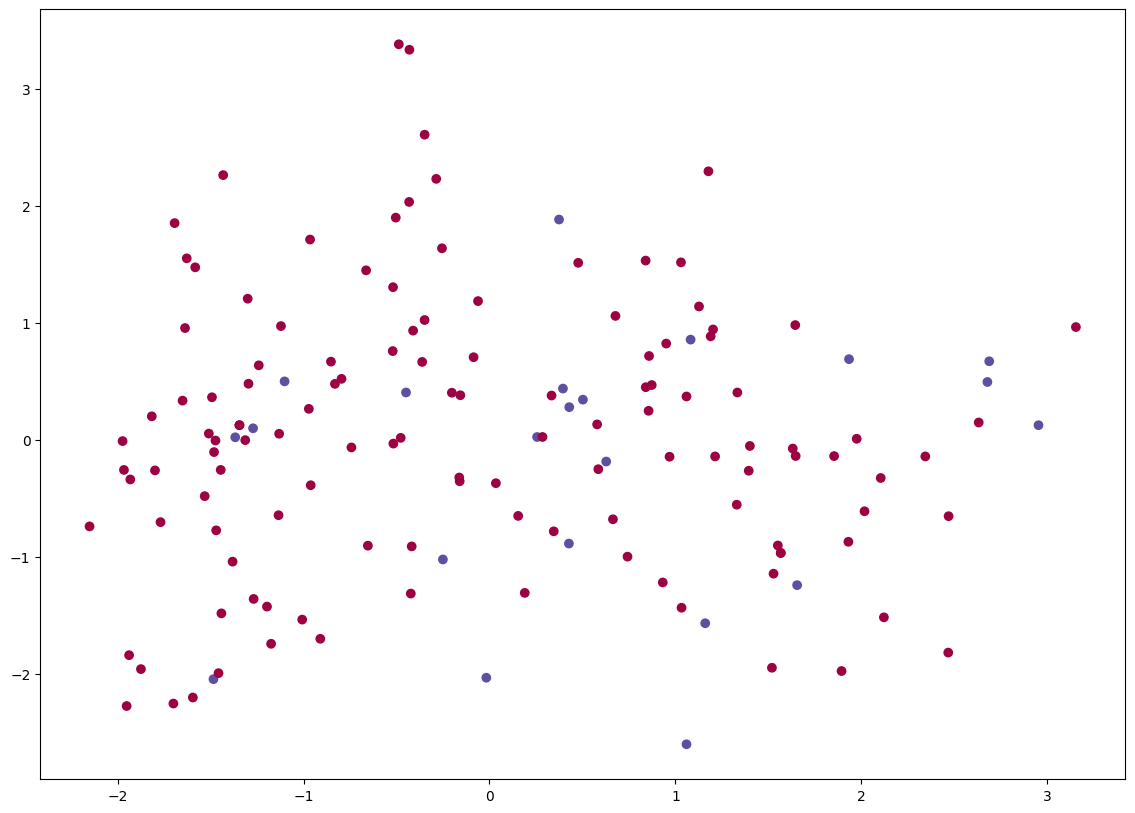

In [5]:
# use umap to visualize the positive and negative classes
import umap
import matplotlib.pyplot as plt
import seaborn as sns

reducer = umap.UMAP(random_state=42)
# use simple imputer to impute missing values
candidate_columns = ['']

# impute missing values
imputer = SimpleImputer(strategy='median')
X_harvard_imputed = imputer.fit_transform(X_harvard)

# scale the data
scaler = StandardScaler()
X_harvard_scaled = scaler.fit_transform(X_harvard_imputed)

# use PCA to reduce the dimensionality
pca = PCA(n_components=2)
X_harvard_pca = pca.fit_transform(X_harvard_scaled)

# plot 
fig, ax = plt.subplots(1, figsize=(14, 10))
color = y_harvard
plt.scatter(*X_harvard_pca.T, c=color, cmap='Spectral', alpha=1.0)


# fit the umap
# embedding = reducer.fit_transform(X_harvard_scaled)

# plot the umap
# fig, ax = plt.subplots(1, figsize=(14, 10))
# color = y_harvard
# plt.scatter(*embedding.T, c=color, cmap='Spectral', alpha=1.0)

## Investigate impact of preprocessing methods

In [59]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=UserWarning)

param_grid = {
    'imputer': [SimpleImputer(strategy='median'), SimpleImputer(strategy='constant', fill_value=0), SimpleImputer(strategy='constant', fill_value=-99), KNNImputer()],
    'scaler': [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()],
}

clf_grid_search_results = []
for j, classifier in enumerate(classifiers):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    tprs = []
    grid_search_results = []
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)
    grid_search_results = []
    for i, (train_index, test_index) in enumerate(sss.split(X_harvard, y_harvard)):
        X_train_harvard, X_test_harvard, y_train_harvard, y_test_harvard = X_harvard.iloc[train_index], X_harvard.iloc[test_index], y_harvard.iloc[train_index], y_harvard.iloc[test_index]
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        pipeline = imbpipeline(steps = [
            ['imputer', SimpleImputer(strategy='median')],
            ['scaler', StandardScaler()],
            ['clf', classifier]
        ])
        grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='f1', n_jobs=-1)
        grid_search.fit(X_train_harvard, y_train_harvard)
        grid_search_results.append(grid_search.cv_results_)
    clf_grid_search_results.append(grid_search_results)


In [60]:
imputer_comparison = {}
scaler_comparison = {}
# for each classifier get the grid search results
for j, clf_results in enumerate(clf_grid_search_results):
    # create a dictionary from imputer parameters with a list of scores for each parameter
    clf_imputer_results = {}
    # add the imputer parameters to the dictionary
    for param in param_grid['imputer']:
        clf_imputer_results[str(param)] = []
    clf_scaler_results = {}
    # add the scaler parameters to the dictionary
    for param in param_grid['scaler']:
        clf_scaler_results[str(param)] = []
    # calculate the average test score for each instance of a parameter
    for grid_search in clf_results:
        # export this grid search
        imputer_results = []
        scaler_results = []
        for param in param_grid['imputer']:
            imputer_results.append(np.mean(grid_search['mean_test_score'][grid_search['param_imputer'] == param]))
        for param in param_grid['scaler']:
            scaler_results.append(np.mean(grid_search['mean_test_score'][grid_search['param_scaler'] == param]))
        # add the results at index 0 to the key at index 0 and so on
        for i, param in enumerate(param_grid['imputer']):
            clf_imputer_results[str(param)].append(imputer_results[i])
        for i, param in enumerate(param_grid['scaler']):
            clf_scaler_results[str(param)].append(scaler_results[i])
    # calculate the mean across each parameter
    for param in param_grid['imputer']:
        clf_imputer_results[str(param)] = np.mean(clf_imputer_results[str(param)])
    for param in param_grid['scaler']:
        clf_scaler_results[str(param)] = np.mean(clf_scaler_results[str(param)])
    # append the results to the dictionary
    imputer_comparison[str(classifiers[j])] = clf_imputer_results
    scaler_comparison[str(classifiers[j])] = clf_scaler_results

# turn the dictionaries into dataframes
imputer_comparison = pd.DataFrame(imputer_comparison)
# export the dataframe
imputer_comparison.to_excel('./data/imputer_comparison.xlsx')
scaler_comparison = pd.DataFrame(scaler_comparison)
# export the dataframe
scaler_comparison.to_excel('./data/scaler_comparison.xlsx')

# => No strong difference between different pre-processing techniques. Using zero fill and MinMax scaling as default setting was best


## K-Fold Model selection

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for DecisionTreeClassifier:
accuracy: 0.7702702702702703 precision: 0.3333333333333333 recall: 0.5454545454545454 f1: 0.41379310344827586 roc_auc: 0.6774891774891775
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for DecisionTreeClassifier:
accuracy: 0.7027027027027027 precision: 0.28 recall: 0.6363636363636364 f1: 0.3888888888888889 roc_auc: 0.6753246753246753
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for DecisionTreeClassifier:
accuracy: 0.7972972972972973 precision: 0.3 recall: 0.2727272727272727 f1: 0.28571428571428564 roc_auc: 0.5808080808080808
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for DecisionTreeClassifier:
accuracy: 0.7702702702702703 precision: 0.3333333333333333 recall: 0.5454545454545454 f1: 0.41379310344827586 roc_auc: 0.6774891774891775
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Results for DecisionTree

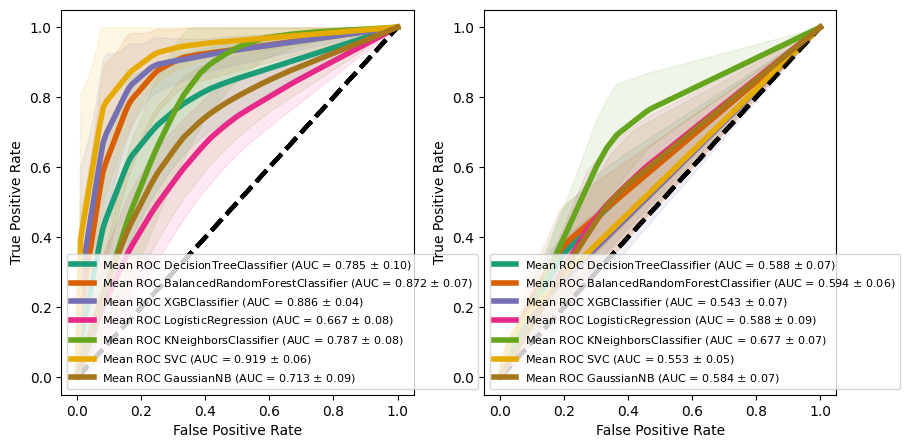

In [55]:
from sklearn.metrics import precision_recall_curve
# suppress user warnings
import warnings
warnings.filterwarnings('ignore')
# copyright for PR curve code: https://amirhessam88.github.io/roc-vs-pr/

test_model_evaluations = {
    'accuracy_scores': [],
    'precision_scores': [],
    'recall_scores': [],
    'f1_scores': [],
    'roc_auc_scores': [],
}

train_model_evaluations = {
    'accuracy_scores': [],
    'precision_scores': [],
    'recall_scores': [],
    'f1_scores': [],
    'roc_auc_scores': [],
}

# create a 2x1 plot
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
colors = plt.get_cmap("Dark2")
param_grids = [
    # DecisionTreeClassifier
    {
        "max_depth": [3, 5 , 10],
        "max_features": ["auto", "sqrt", "log2", None],
        "min_samples_leaf": [1,5,10],
        "criterion": ["gini", "entropy"],
    },
    # BalancedRandomForestClassifier
    {   
        'criterion':['gini','entropy'],
        'n_estimators':[10,20,30],
        'min_samples_leaf':[1,3,5],
        'min_samples_split':[3,5,7], 
        'max_features':['auto','sqrt','log2'],
        'max_depth':[2,3,5],
        'class_weight' : ["balanced", "balanced_subsample"]
    }, 
    # # XGBClassifier
    {
        'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
        'n_estimators':[10,20,30,40,100],
        'max_depth':[2,3,5],
        'colsample_bytree':[0.1,0.3,0.5,1],
        'subsample':[0.1,0.3,0.5,1],
    }, 
    # Logistic Regression
    {
        "penalty" : ["l2","l1"],
        "tol" : [0.0001,0.0002,0.0003],
        "max_iter": [100,200,300],
        "C" :[0.001,0.01, 0.1, 1, 10, 100],
        "intercept_scaling": [1, 2, 3, 4],
    },
    # # KNN
    {
        'n_neighbors':[5,6,7,8,9,10],
        'leaf_size':[1,2,3,5],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree','kd_tree','brute'],
        
    },
    # # SVM
    {
        'kernel': ['rbf','linear'], 
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,'auto'],
        'C': [1, 6, 7, 8, 9, 10, 11, 12, 10, 50, 100, 200, 300],
    },
    # Naive Bayes
    { },
]

classifier_cv_results = []
best_models = []
for j, classifier in enumerate(classifiers):
    name = str(classifier.__class__.__name__)
    
    train_accuracy_scores = []
    train_precision_scores = []
    train_recall_scores = []
    train_f1_scores = []
    train_roc_auc_scores = []

    test_accuracy_scores = []
    test_precision_scores = []
    test_recall_scores = []
    test_f1_scores = []
    test_roc_auc_scores = []

    grid_search_results = []

    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42)

    train_tprs = []
    test_tprs = []
    interpolation_points = np.linspace(0, 1, 100)
    for i, (train_index, test_index) in enumerate(sss.split(X_harvard, y_harvard)):
        X_train_harvard, X_test_harvard, y_train_harvard, y_test_harvard = X_harvard.iloc[train_index], X_harvard.iloc[test_index], y_harvard.iloc[train_index], y_harvard.iloc[test_index]
        preprocessing = Pipeline(steps=[
            ['imputer', SimpleImputer(strategy='median')],
            ['scaler', StandardScaler()],
        ])
        # apply preprocessing to train and test set
        X_train_harvard = preprocessing.fit_transform(X_train_harvard)
        X_test_harvard = preprocessing.transform(X_test_harvard)
        # apply smote to train set
        smote = SMOTE(random_state=42)
        X_train_harvard, y_train_harvard = smote.fit_resample(X_train_harvard, y_train_harvard)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        param_grid = param_grids[j]
        grid_search = GridSearchCV(
            classifier,
            param_grid,
            scoring='roc_auc',
            # cv=kfold,
            return_train_score=True,
            verbose=1,
            n_jobs=-1,
        )
        grid_search.fit(X_train_harvard, y_train_harvard)
        cv_results = pd.DataFrame(grid_search.cv_results_)
        grid_search_results.append(cv_results)
        model = grid_search.best_estimator_
        # create k-fold roc curve on train set
        for train_index, test_index in kfold.split(X_train_harvard, y_train_harvard):
            X_train_cv, X_test_cv = X_train_harvard[train_index], X_train_harvard[test_index]
            y_train_cv, y_test_cv = y_train_harvard[train_index], y_train_harvard[test_index]
            model.fit(X_train_cv, y_train_cv)
            y_pred_train = model.predict(X_test_cv)
            train_fpr, train_tpr, thresholds = roc_curve(y_test_cv, y_pred_train)
            train_tprs.append(np.interp(interpolation_points, train_fpr, train_tpr))
            train_tprs[-1][0] = 0.0
            train_roc_auc = auc(train_fpr, train_tpr)
            train_accuracy_scores.append(accuracy_score(y_test_cv, y_pred_train))
            train_precision_scores.append(precision_score(y_test_cv, y_pred_train))
            train_recall_scores.append(recall_score(y_test_cv, y_pred_train))
            train_f1_scores.append(f1_score(y_test_cv, y_pred_train))
            train_roc_auc_scores.append(train_roc_auc)
        # now evaluate on test set
        model.fit(X_train_harvard, y_train_harvard)
        y_pred_test = model.predict(X_test_harvard)
        
        # compute roc curve
        test_fpr, test_tpr, thresholds = roc_curve(y_test_harvard, y_pred_test)
        test_tprs.append(np.interp(interpolation_points, test_fpr, test_tpr))
        test_tprs[-1][0] = 0.0
        test_roc_auc = auc(test_fpr, test_tpr)

        test_accuracy_scores.append(accuracy_score(y_test_harvard, y_pred_test))
        test_precision_scores.append(precision_score(y_test_harvard, y_pred_test))
        test_recall_scores.append(recall_score(y_test_harvard, y_pred_test))
        test_f1_scores.append(f1_score(y_test_harvard, y_pred_test))
        test_roc_auc_scores.append(test_roc_auc)

        print("Results for " + str(name) + ":")
        # print(grid_search.best_params_)
        # print(grid_search.best_score_)
        print("accuracy: "+str(test_accuracy_scores[-1]), "precision: "+str(test_precision_scores[-1]), "recall: "+str(test_recall_scores[-1]), "f1: "+str(test_f1_scores[-1]), "roc_auc: "+str(test_roc_auc_scores[-1]))
    
    classifier_cv_results.append(grid_search_results)
    
    test_model_evaluations['accuracy_scores'].append(test_accuracy_scores)
    test_model_evaluations['precision_scores'].append(test_precision_scores)
    test_model_evaluations['recall_scores'].append(test_recall_scores)
    test_model_evaluations['f1_scores'].append(test_f1_scores)
    test_model_evaluations['roc_auc_scores'].append(test_roc_auc_scores)

    train_model_evaluations['accuracy_scores'].append(train_accuracy_scores)
    train_model_evaluations['precision_scores'].append(train_precision_scores)
    train_model_evaluations['recall_scores'].append(train_recall_scores)
    train_model_evaluations['f1_scores'].append(train_f1_scores)
    train_model_evaluations['roc_auc_scores'].append(train_roc_auc_scores)
    
    ax[0].plot([0, 1], [0, 1], linestyle='--', lw=3, color='k',alpha=.8)
    ax[1].plot([0, 1], [0, 1], linestyle='--', lw=3, color='k',alpha=.8)

    mean_tpr_train = np.mean(train_tprs, axis=0)
    mean_tpr_train[-1] = 1.0
    mean_auc_train = np.mean(train_roc_auc_scores)
    std_auc_train = np.std(train_roc_auc_scores)
    ax[0].plot(interpolation_points, mean_tpr_train, color=colors(j),
                label=r'Mean ROC %s (AUC = %0.3f $\pm$ %0.2f)' % (name, mean_auc_train, std_auc_train),
                lw=4)
    
    std_tpr_train = np.std(train_tprs, axis=0)
    tprs_upper_train = np.minimum(mean_tpr_train + std_tpr_train, 1)
    tprs_lower_train = np.maximum(mean_tpr_train - std_tpr_train, 0)
    ax[0].fill_between(interpolation_points, tprs_lower_train, tprs_upper_train, color=colors(j), alpha=.1,)
    ax[0].set_xlim([-0.05, 1.05])
    ax[0].set_ylim([-0.05, 1.05])
    ax[0].set_xlabel('False Positive Rate', fontsize=10)
    ax[0].set_ylabel('True Positive Rate', fontsize=10)
    ax[0].tick_params(axis='both', which='major', labelsize=10)
    ax[0].legend(fontsize=8)


    mean_tpr_test = np.mean(test_tprs, axis=0)
    mean_tpr_test[-1] = 1.0
    mean_auc_test = np.mean(test_roc_auc_scores)
    std_auc_test = np.std(test_roc_auc_scores)
    ax[1].plot(interpolation_points, mean_tpr_test, color=colors(j),
             label=r'Mean ROC %s (AUC = %0.3f $\pm$ %0.2f)' % (name, mean_auc_test, std_auc_test),
             lw=4)


    std_tpr_test = np.std(test_tprs, axis=0)
    tprs_upper_test = np.minimum(mean_tpr_test + std_tpr_test, 1)
    tprs_lower_test = np.maximum(mean_tpr_test - std_tpr_test, 0)
    ax[1].fill_between(interpolation_points, tprs_lower_test, tprs_upper_test, color=colors(j), alpha=.1,)
    ax[1].set_xlim([-0.05, 1.05])
    ax[1].set_ylim([-0.05, 1.05])
    ax[1].set_xlabel('False Positive Rate',fontsize=10)
    ax[1].set_ylabel('True Positive Rate', fontsize=10)
    ax[1].tick_params(axis='both', which='major', labelsize=10)
    # set smaller legend size
    ax[1].legend(fontsize=8)

    
    
# make text editable in svg
plt.rcParams['svg.fonttype'] = 'none'
# save plot as svg
plt.savefig('./data/roc_curve.svg', format='svg', dpi=1200)
    

In [44]:
train_model_evaluations_copy = train_model_evaluations.copy()
train_model_evaluations_copy = pd.DataFrame(train_model_evaluations_copy)
# turn each cell (list of values) into mean and std
train_model_evaluations_copy['accuracy_scores'] = train_model_evaluations_copy['accuracy_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
train_model_evaluations_copy['precision_scores'] = train_model_evaluations_copy['precision_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
train_model_evaluations_copy['recall_scores'] = train_model_evaluations_copy['recall_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
train_model_evaluations_copy['f1_scores'] = train_model_evaluations_copy['f1_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
train_model_evaluations_copy['roc_auc_scores'] = train_model_evaluations_copy['roc_auc_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
train_model_evaluations_copy.index = [classifier.__class__.__name__ for classifier in classifiers]
train_model_evaluations_copy

,accuracy_scores,precision_scores,recall_scores,f1_scores,roc_auc_scores
DecisionTreeClassifier,0.81 (0.08),0.81 (0.1),0.83 (0.13),0.81 (0.09),0.81 (0.08)
BalancedRandomForestClassifier,0.88 (0.06),0.88 (0.08),0.9 (0.08),0.88 (0.06),0.88 (0.06)
XGBClassifier,0.89 (0.06),0.9 (0.09),0.9 (0.09),0.89 (0.06),0.89 (0.06)
LogisticRegression,0.8 (0.07),0.77 (0.09),0.88 (0.11),0.81 (0.07),0.8 (0.07)
KNeighborsClassifier,0.76 (0.08),0.68 (0.07),0.99 (0.03),0.81 (0.05),0.76 (0.08)
SVC,0.94 (0.06),0.94 (0.07),0.96 (0.1),0.94 (0.07),0.94 (0.06)
GaussianNB,0.76 (0.11),0.74 (0.14),0.87 (0.12),0.79 (0.08),0.76 (0.11)


In [45]:
# copy the model evaluations dictionary
test_model_evaluations_copy = test_model_evaluations.copy()
test_model_evaluations_copy = pd.DataFrame(test_model_evaluations_copy)
# turn each cell (list of values) into mean and std
test_model_evaluations_copy['accuracy_scores'] = test_model_evaluations_copy['accuracy_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
test_model_evaluations_copy['precision_scores'] = test_model_evaluations_copy['precision_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
test_model_evaluations_copy['recall_scores'] = test_model_evaluations_copy['recall_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
test_model_evaluations_copy['f1_scores'] = test_model_evaluations_copy['f1_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
test_model_evaluations_copy['roc_auc_scores'] = test_model_evaluations_copy['roc_auc_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
test_model_evaluations_copy.index = [classifier.__class__.__name__ for classifier in classifiers]
test_model_evaluations_copy



,accuracy_scores,precision_scores,recall_scores,f1_scores,roc_auc_scores
DecisionTreeClassifier,0.72 (0.05),0.22 (0.1),0.35 (0.16),0.26 (0.11),0.57 (0.07)
BalancedRandomForestClassifier,0.79 (0.05),0.27 (0.16),0.16 (0.11),0.19 (0.1),0.53 (0.06)
XGBClassifier,0.82 (0.03),0.32 (0.12),0.18 (0.11),0.22 (0.09),0.55 (0.04)
LogisticRegression,0.68 (0.04),0.21 (0.05),0.41 (0.12),0.27 (0.07),0.57 (0.06)
KNeighborsClassifier,0.59 (0.04),0.23 (0.03),0.72 (0.09),0.35 (0.04),0.65 (0.05)
SVC,0.81 (0.03),0.2 (0.15),0.1 (0.08),0.13 (0.09),0.52 (0.03)
GaussianNB,0.64 (0.18),0.26 (0.09),0.58 (0.22),0.34 (0.09),0.62 (0.07)


In [55]:
# analyze what hyperparameters are used for each classifier
for classifier_cv_result in classifier_cv_results:
    clf_param_settings = {}
    clf_param_results = []
    # get the name of each parameter
    grid_search_result = classifier_cv_result[0]
    param_names = []
    for param in grid_search_result.columns:
        if param.startswith("param_"):
            param_names.append(param)
    for grid_search in classifier_cv_result:
        param_settings = {}
        for param in param_names:
            # add each parameter setting to the dictionary
            for param_setting in grid_search[param].unique():
                if param_settings.get(param) == None:
                    param_settings[param] = []
                param_settings[param].append(param_setting)
        param_results = {}
        for param in param_names:
            param_results[param] = []
            # get  each variant of the parameter
            for param_variant in grid_search[param].unique():
                # get the mean test score for all combinations with that parameter
                param_results[param].append(np.mean(grid_search['mean_test_score'][grid_search[param] == param_variant]))
        if clf_param_settings == {}:
            clf_param_settings = param_settings
        clf_param_results.append(param_results)
    # print(clf_param_settings)
    # print(clf_param_results)
    # for each parameter get the mean test score for each variant
    mean_param_results = {}
    for param in param_names:
        mean_param_results[param] = []
        for param_setting in clf_param_settings[param]:
            mean_param_results[param].append(np.mean([param_result[param][clf_param_settings[param].index(param_setting)] for param_result in clf_param_results]))
    # print(mean_param_results)
    # print the best setting for each parameter
    for param in param_names:
        print(param + ": " + str(clf_param_settings[param][mean_param_results[param].index(max(mean_param_results[param]))]))
    print("---------")

param_criterion: entropy
param_max_depth: 10
param_max_features: auto
param_min_samples_leaf: 5
---------
param_class_weight: balanced
param_criterion: gini
param_max_depth: 5
param_max_features: log2
param_min_samples_leaf: 1
param_min_samples_split: 3
param_n_estimators: 30
---------
param_colsample_bytree: 0.5
param_learning_rate: 0.2
param_max_depth: 5
param_n_estimators: 100
param_subsample: 1
---------
param_C: 1
param_intercept_scaling: 4
param_max_iter: 100
param_penalty: l2
param_tol: 0.0003
---------
param_algorithm: auto
param_leaf_size: 1
param_n_neighbors: 5
param_weights: distance
---------
param_C: 200
param_gamma: 1
param_kernel: rbf
---------
---------


## Benchmarking

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Results for BODE:
accuracy: 0.6081081081081081 precision: 0.23529411764705882 recall: 0.7272727272727273 f1: 0.3555555555555555 roc_auc: 0.6572871572871573
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Results for BODE:
accuracy: 0.5540540540540541 precision: 0.21052631578947367 recall: 0.7272727272727273 f1: 0.32653061224489793 roc_auc: 0.6255411255411255
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Results for BODE:
accuracy: 0.6756756756756757 precision: 0.30303030303030304 recall: 0.9090909090909091 f1: 0.45454545454545453 roc_auc: 0.772005772005772
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Results for BODE:
accuracy: 0.7837837837837838 precision: 0.3333333333333333 recall: 0.45454545454545453 f1: 0.3846153846153846 roc_auc: 0.6479076479076479
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Results for BODE:
accuracy: 0.6486486486486487 precisio

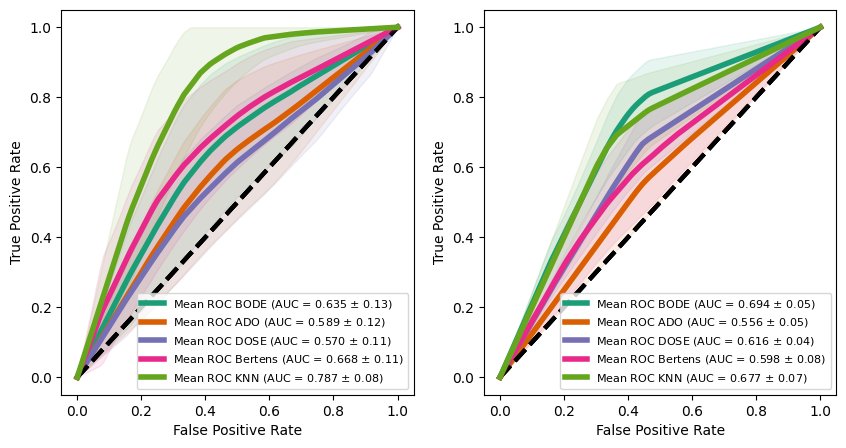

In [46]:
# import ROC curve display
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# https://www.nejm.org/doi/full/10.1056/nejmoa021322
def calculate_BODE(X):
    # turn string into int
    X['% FEV1 a'] = float(X['% FEV1 a'])
    X['MMRC'] = float(X['MMRC'])
    X['6MWT'] = float(X['6MWT'])
    score = 0
    if X['% FEV1 a'] >= 50 and X['% FEV1 a'] <= 64:
        score += 1
    if X['% FEV1 a'] >= 36 and X['% FEV1 a'] <= 49:
        score += 2
    if X['% FEV1 a'] <= 35:
        score += 3
    # our MMRC goes from 1 - 5 so we need to add 1 to the BODE score for each MMRC
    if X['MMRC'] == 3:
        score += 1
    if X['MMRC'] == 4:
        score += 2
    if X['MMRC'] == 5:
        score += 3
    if X['6MWT'] >= 250 and X['6MWT'] <= 349:
        score += 1
    if X['6MWT'] >= 150 and X['6MWT'] <= 249:
        score += 2
    if X['6MWT'] <= 149:
        score += 3
    if X['BMI'] <= 21:
        score += 1
    return score

# https://www.thelancet.com/article/S0140-6736(09)61301-5/fulltext
def calculate_ADO(X):
    X['% FEV1 a'] = float(X['% FEV1 a'])
    X['MMRC'] = float(X['MMRC'])
    score = 0
    if X['Age'] >= 50 and X['Age'] <= 59:
        score += 1
    if X['Age'] >= 60 and X['Age'] <= 69:
        score += 2
    if X['Age'] >= 70 and X['Age'] <= 79:
        score += 3
    if X['Age'] >= 80 and X['Age'] <= 89:
        score += 4
    if X['Age'] >= 90:
        score += 5
    if X['MMRC'] == 3:
        score += 1
    if X['MMRC'] == 4:
        score += 2
    if X['MMRC'] == 5:
        score += 3
    if X['% FEV1 a'] >= 36 and X['% FEV1 a'] <= 64:
        score += 1
    if X['% FEV1 a'] <= 35:
        score += 2
    return score

# https://www.atsjournals.org/doi/full/10.1164/rccm.200902-0271OC
def calculate_DOSE(X):
    X['% FEV1 a'] = float(X['% FEV1 a'])
    X['MMRC'] = float(X['MMRC'])
    score = 0
    if X['MMRC'] == 3:
        score += 2
    if X['MMRC'] == 4:
        score += 3
    if X['MMRC'] == 5:
        score += 4
    if X['% FEV1 a'] >= 30 and X['% FEV1 a'] <= 49:
        score += 1
    if X['% FEV1 a'] < 30:
        score += 2
    # all patients smoke so add 1 point
    score += 1
    if X['Exa. last 12 months'] == 3:
        score += 2
    return score

harvard_copy = df_harvard.copy()
X_harvard = harvard_copy.drop(['Exacerbation'], axis=1)
y_harvard = harvard_copy['Exacerbation']
X_harvard['BODE'] = X_harvard.apply(calculate_BODE, axis=1)
X_harvard['ADO'] = X_harvard.apply(calculate_ADO, axis=1)
X_harvard['DOSE'] = X_harvard.apply(calculate_DOSE, axis=1)

test_model_evaluations = {
    'accuracy_scores': [],
    'precision_scores': [],
    'recall_scores': [],
    'f1_scores': [],
    'roc_auc_scores': [],
}
train_model_evaluations = {
    'accuracy_scores': [],
    'precision_scores': [],
    'recall_scores': [],
    'f1_scores': [],
    'roc_auc_scores': [],
}

colors = plt.get_cmap("Dark2")

knn_params = {
    'n_neighbors':[5,6,7,8,9,10],
    'leaf_size':[1,2,3,5],
    'weights':['uniform', 'distance'],
    'algorithm':['auto', 'ball_tree','kd_tree','brute'],   
}

lr_params = {
    "penalty" : ["l2","l1"],
    "tol" : [0.0001,0.0002,0.0003],
    "max_iter": [100,200,300],
    "C" :[0.001,0.01, 0.1, 1, 10, 100],
    "intercept_scaling": [1, 2, 3, 4],
}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
colors = plt.get_cmap("Dark2")
model_names =["BODE", "ADO", "DOSE", "Bertens", "KNN"]
bertens_columns = ["Exa. last 12 months", "% FEV1 a", "Pack years", "Coronary Artery Disease"]
KNN_columns = ['FEV1/FVC x 100 a', '6MWT', 'Height', 'Exa. last 12 months', 'Rescue Inhaler', 'ER visits last 12 months', 'MMRC']
# check if all bertens columns are in the dataframe
for j, model_name in enumerate(model_names):
    # perform k-fold cv 10 times due to train test split sensitivity
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42)

    train_accuracy_scores = []
    train_precision_scores = []
    train_recall_scores = []
    train_f1_scores = []
    train_roc_auc_scores = []

    test_accuracy_scores = []
    test_precision_scores = []
    test_recall_scores = []
    test_f1_scores = []
    test_roc_auc_scores = []

    train_tprs = []
    train_aucs = []
    
    test_fprs = []
    test_tprs = []
    # points at which to interpolate
    interpolation_points = np.linspace(0, 1, 100)
    # copy to avoid changing the original dataframe during feature selection
    X_harvard_copy = X_harvard.copy()
    if model_name != "Bertens" and model_name != "KNN":
        # just keep the column with the name of the model
        X_harvard_copy = X_harvard_copy[[model_name]]
    if model_name == "Bertens":
        # just keep the Bertens columns
        X_harvard_copy = X_harvard_copy[bertens_columns]
    if model_name == "KNN":
        # just keep the best selected columns
        X_harvard_copy = X_harvard_copy[KNN_columns]
    for i, (train_index, test_index) in enumerate(sss.split(X_harvard_copy, y_harvard)):
        X_train_harvard, X_test_harvard, y_train_harvard, y_test_harvard = X_harvard_copy.iloc[train_index], X_harvard_copy.iloc[test_index], y_harvard.iloc[train_index], y_harvard.iloc[test_index]
        preprocessing = Pipeline(steps=[
            ['imputer', SimpleImputer(strategy='median')],
            ['scaler', StandardScaler()],
        ])
         # apply preprocessing to train and test set
        X_train_harvard = preprocessing.fit_transform(X_train_harvard)
        X_test_harvard = preprocessing.transform(X_test_harvard)
        # apply smote to train set
        smote = SMOTE(random_state=42)
        X_train_harvard, y_train_harvard = smote.fit_resample(X_train_harvard, y_train_harvard)
        kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        model = LogisticRegression(random_state=42, class_weight='balanced', n_jobs=-1, solver='liblinear')
        relevant_params = lr_params
        if model_name == "KNN":
            # initialize KNN with best parameters
            model = KNeighborsClassifier(n_jobs=-1)
            relevant_params = knn_params
        grid_search = GridSearchCV(
            model,
            relevant_params,
            scoring='roc_auc',
            # cv=kfold,
            return_train_score=True,
            verbose=1,
            n_jobs=-1,
        )
        grid_search.fit(X_train_harvard, y_train_harvard)
        model = grid_search.best_estimator_
        # create k-fold roc curve on train set
        for train_index, test_index in kfold.split(X_train_harvard, y_train_harvard):
            X_train_cv, X_test_cv = X_train_harvard[train_index], X_train_harvard[test_index]
            y_train_cv, y_test_cv = y_train_harvard[train_index], y_train_harvard[test_index]
            model.fit(X_train_cv, y_train_cv)
            y_pred_train = model.predict(X_test_cv)
            train_fpr, train_tpr, thresholds = roc_curve(y_test_cv, y_pred_train)
            train_tprs.append(np.interp(interpolation_points, train_fpr, train_tpr))
            train_tprs[-1][0] = 0.0
            train_roc_auc = auc(train_fpr, train_tpr)
            train_accuracy_scores.append(accuracy_score(y_test_cv, y_pred_train))
            train_precision_scores.append(precision_score(y_test_cv, y_pred_train))
            train_recall_scores.append(recall_score(y_test_cv, y_pred_train))
            train_f1_scores.append(f1_score(y_test_cv, y_pred_train))
            train_roc_auc_scores.append(train_roc_auc)
        # now evaluate on test set
        model.fit(X_train_harvard, y_train_harvard)
        y_pred_test = model.predict(X_test_harvard)
        
        # compute roc curve
        test_fpr, test_tpr, thresholds = roc_curve(y_test_harvard, y_pred_test)
        test_tprs.append(np.interp(interpolation_points, test_fpr, test_tpr))
        test_tprs[-1][0] = 0.0
        test_roc_auc = auc(test_fpr, test_tpr)

        test_accuracy_scores.append(accuracy_score(y_test_harvard, y_pred_test))
        test_precision_scores.append(precision_score(y_test_harvard, y_pred_test))
        test_recall_scores.append(recall_score(y_test_harvard, y_pred_test))
        test_f1_scores.append(f1_score(y_test_harvard, y_pred_test))
        test_roc_auc_scores.append(test_roc_auc)

        print("Results for " + str(model_name) + ":")
        # print(grid_search.best_params_)
        # print(grid_search.best_score_)
        print("accuracy: "+str(test_accuracy_scores[-1]), "precision: "+str(test_precision_scores[-1]), "recall: "+str(test_recall_scores[-1]), "f1: "+str(test_f1_scores[-1]), "roc_auc: "+str(test_roc_auc_scores[-1]))
    

    classifier_cv_results.append(grid_search_results)
    
    test_model_evaluations['accuracy_scores'].append(test_accuracy_scores)
    test_model_evaluations['precision_scores'].append(test_precision_scores)
    test_model_evaluations['recall_scores'].append(test_recall_scores)
    test_model_evaluations['f1_scores'].append(test_f1_scores)
    test_model_evaluations['roc_auc_scores'].append(test_roc_auc_scores)

    train_model_evaluations['accuracy_scores'].append(train_accuracy_scores)
    train_model_evaluations['precision_scores'].append(train_precision_scores)
    train_model_evaluations['recall_scores'].append(train_recall_scores)
    train_model_evaluations['f1_scores'].append(train_f1_scores)
    train_model_evaluations['roc_auc_scores'].append(train_roc_auc_scores)
    
    ax[0].plot([0, 1], [0, 1], linestyle='--', lw=3, color='k',alpha=.8)
    ax[1].plot([0, 1], [0, 1], linestyle='--', lw=3, color='k',alpha=.8)

    mean_tpr_train = np.mean(train_tprs, axis=0)
    mean_tpr_train[-1] = 1.0
    mean_auc_train = np.mean(train_roc_auc_scores)
    std_auc_train = np.std(train_roc_auc_scores)
    ax[0].plot(interpolation_points, mean_tpr_train, color=colors(j),
                label=r'Mean ROC %s (AUC = %0.3f $\pm$ %0.2f)' % (model_name, mean_auc_train, std_auc_train),
                lw=4)
    
    std_tpr_train = np.std(train_tprs, axis=0)
    tprs_upper_train = np.minimum(mean_tpr_train + std_tpr_train, 1)
    tprs_lower_train = np.maximum(mean_tpr_train - std_tpr_train, 0)
    ax[0].fill_between(interpolation_points, tprs_lower_train, tprs_upper_train, color=colors(j), alpha=.1,)
    ax[0].set_xlim([-0.05, 1.05])
    ax[0].set_ylim([-0.05, 1.05])
    ax[0].set_xlabel('False Positive Rate', fontsize=10)
    ax[0].set_ylabel('True Positive Rate', fontsize=10)
    ax[0].tick_params(axis='both', which='major', labelsize=10)
    ax[0].legend(fontsize=8)


    mean_tpr_test = np.mean(test_tprs, axis=0)
    mean_tpr_test[-1] = 1.0
    mean_auc_test = np.mean(test_roc_auc_scores)
    std_auc_test = np.std(test_roc_auc_scores)
    ax[1].plot(interpolation_points, mean_tpr_test, color=colors(j),
             label=r'Mean ROC %s (AUC = %0.3f $\pm$ %0.2f)' % (model_name, mean_auc_test, std_auc_test),
             lw=4)


    std_tpr_test = np.std(test_tprs, axis=0)
    tprs_upper_test = np.minimum(mean_tpr_test + std_tpr_test, 1)
    tprs_lower_test = np.maximum(mean_tpr_test - std_tpr_test, 0)
    ax[1].fill_between(interpolation_points, tprs_lower_test, tprs_upper_test, color=colors(j), alpha=.1,)
    ax[1].set_xlim([-0.05, 1.05])
    ax[1].set_ylim([-0.05, 1.05])
    ax[1].set_xlabel('False Positive Rate',fontsize=10)
    ax[1].set_ylabel('True Positive Rate', fontsize=10)
    ax[1].tick_params(axis='both', which='major', labelsize=10)
    # set smaller legend size
    ax[1].legend(fontsize=8)

    
    
# make text editable in svg
plt.rcParams['svg.fonttype'] = 'none'

# save plot as svg
plt.savefig('./results/benchmark_roc_curve_harvard.svg', format='svg', dpi=1200)

# axes[0].set_xlabel("False Positive Rate")
# axes[0].set_ylabel("True Positive Rate")
# axes[0].set_title("ROC Curve (Train Set)")
# axes[0].legend(fontsize='small')

# axes[1].set_xlabel("False Positive Rate")
# axes[1].set_ylabel("True Positive Rate")
# axes[1].set_title("ROC Curve (Test Set)")
# axes[1].legend(fontsize='small')

# BODEx: BMI, fev1, mmrc, 6MWD, exacerbation
# Bertens: prev. exa, % pred. FEV1, pack years, history of vascular disease
# Accept: Age, % pred FEV1, BMI, SGRQ, Sex, Current-Smoker, On-Statin, O2-Therapy, On-LAMA, On-LABA, On-ICS

In [47]:
train_model_evaluations_copy = train_model_evaluations.copy()
train_model_evaluations_copy = pd.DataFrame(train_model_evaluations_copy)
# turn each cell (list of values) into mean and std
train_model_evaluations_copy['accuracy_scores'] = train_model_evaluations_copy['accuracy_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
train_model_evaluations_copy['precision_scores'] = train_model_evaluations_copy['precision_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
train_model_evaluations_copy['recall_scores'] = train_model_evaluations_copy['recall_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
train_model_evaluations_copy['f1_scores'] = train_model_evaluations_copy['f1_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
train_model_evaluations_copy['roc_auc_scores'] = train_model_evaluations_copy['roc_auc_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
train_model_evaluations_copy.index = [model_name for model_name in model_names]
train_model_evaluations_copy

,accuracy_scores,precision_scores,recall_scores,f1_scores,roc_auc_scores
BODE,0.63 (0.13),0.59 (0.15),0.7 (0.25),0.64 (0.19),0.63 (0.13)
ADO,0.59 (0.12),0.52 (0.2),0.61 (0.26),0.56 (0.22),0.59 (0.12)
DOSE,0.57 (0.11),0.57 (0.1),0.6 (0.16),0.58 (0.11),0.57 (0.11)
Bertens,0.67 (0.11),0.66 (0.11),0.73 (0.17),0.68 (0.11),0.67 (0.11)
KNN,0.79 (0.08),0.72 (0.07),0.97 (0.05),0.82 (0.06),0.79 (0.08)


In [48]:
# copy the model evaluations dictionary
test_model_evaluations_copy = test_model_evaluations.copy()
test_model_evaluations_copy = pd.DataFrame(test_model_evaluations_copy)
# turn each cell (list of values) into mean and std
test_model_evaluations_copy['accuracy_scores'] = test_model_evaluations_copy['accuracy_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
test_model_evaluations_copy['precision_scores'] = test_model_evaluations_copy['precision_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
test_model_evaluations_copy['recall_scores'] = test_model_evaluations_copy['recall_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
test_model_evaluations_copy['f1_scores'] = test_model_evaluations_copy['f1_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
test_model_evaluations_copy['roc_auc_scores'] = test_model_evaluations_copy['roc_auc_scores'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
test_model_evaluations_copy.index = [model_name for model_name in model_names]
test_model_evaluations_copy



,accuracy_scores,precision_scores,recall_scores,f1_scores,roc_auc_scores
BODE,0.64 (0.06),0.26 (0.03),0.77 (0.14),0.39 (0.04),0.69 (0.05)
ADO,0.56 (0.11),0.16 (0.06),0.55 (0.2),0.25 (0.09),0.56 (0.05)
DOSE,0.6 (0.05),0.21 (0.02),0.64 (0.15),0.32 (0.04),0.62 (0.04)
Bertens,0.6 (0.09),0.21 (0.06),0.6 (0.14),0.31 (0.07),0.6 (0.08)
KNN,0.64 (0.06),0.26 (0.04),0.73 (0.12),0.38 (0.06),0.68 (0.07)


# Single Dataset classification Triage

## Initial Setup

In [61]:
# now we try classification using k-fold cross validation
from numpy import ndarray
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, make_scorer
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve

triage_copy = df_triage.copy()
triage_copy.dropna(subset=['Exacerbation'], inplace=True)
# now only consider smokers
# triage_copy = triage_copy[triage_copy['Smoker'] == 1]
# get all the variables that are not the target variable
X = triage_copy.drop(columns=['Exacerbation'])
# get the target variable
y = triage_copy['Exacerbation']
print(y.value_counts())
y = LabelEncoder().fit_transform(y)

# print unique values with value counts y
print(np.unique(y, return_counts=True))

candidate_predictors = ['Cough details', 'Wheezing details', 'Sputum details', 'Ox Saturation b', 'Worse Symptoms', 'Dyspnea details', 'Increase in sputum', '% FEV1 b', 'Heartrate a', 'BMI', 'MMRC b', 'Heartrate b', 'Wheezing']

# create a train test split
X_train_triage, X_test_triage, y_train_triage, y_test_triage = train_test_split(X[candidate_predictors], y, test_size=0.3, random_state=42)

classifiers = [
    DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample'), 
    XGBClassifier(random_state=42, n_jobs=-1), 
    LogisticRegression(random_state=42, class_weight='balanced', n_jobs=-1, solver='liblinear'), 
    KNeighborsClassifier(n_jobs=-1),
    SVC(probability=True, class_weight='balanced'),
    GaussianNB(),
]

Exacerbation
0    589
1    547
Name: count, dtype: int64
(array([0, 1], dtype=int64), array([589, 547], dtype=int64))


## Investigate impact of pre-processing technique

In [56]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=UserWarning)

param_grid = {
    'imputer': [SimpleImputer(strategy='median'), SimpleImputer(strategy='constant', fill_value=0), SimpleImputer(strategy='constant', fill_value=-99), KNNImputer()],
    'scaler': [StandardScaler(), MinMaxScaler(), Normalizer(), MaxAbsScaler()],
}

clf_grid_search_results = []
for j, classifier in enumerate(classifiers):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    tprs = []
    grid_search_results = []
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    pipeline = imbpipeline(steps = [
        ['imputer', SimpleImputer(strategy='median')],
        ['scaler', StandardScaler()],
        ['clf', classifier]
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_triage, y_train_triage)
    grid_search_results.append(grid_search.cv_results_)
    clf_grid_search_results.append(grid_search_results)


In [58]:
imputer_comparison = {}
scaler_comparison = {}
# for each classifier get the grid search results
for j, clf_results in enumerate(clf_grid_search_results):
    # create a dictionary from imputer parameters with a list of scores for each parameter
    clf_imputer_results = {}
    # add the imputer parameters to the dictionary
    for param in param_grid['imputer']:
        clf_imputer_results[str(param)] = []
    clf_scaler_results = {}
    # add the scaler parameters to the dictionary
    for param in param_grid['scaler']:
        clf_scaler_results[str(param)] = []
    # calculate the average test score for each instance of a parameter
    for grid_search in clf_results:
        # export this grid search
        imputer_results = []
        scaler_results = []
        for param in param_grid['imputer']:
            imputer_results.append(np.mean(grid_search['mean_test_score'][grid_search['param_imputer'] == param]))
        for param in param_grid['scaler']:
            scaler_results.append(np.mean(grid_search['mean_test_score'][grid_search['param_scaler'] == param]))
        # add the results at index 0 to the key at index 0 and so on
        for i, param in enumerate(param_grid['imputer']):
            clf_imputer_results[str(param)].append(imputer_results[i])
        for i, param in enumerate(param_grid['scaler']):
            clf_scaler_results[str(param)].append(scaler_results[i])
    # calculate the mean across each parameter
    for param in param_grid['imputer']:
        clf_imputer_results[str(param)] = np.mean(clf_imputer_results[str(param)])
    for param in param_grid['scaler']:
        clf_scaler_results[str(param)] = np.mean(clf_scaler_results[str(param)])
    # append the results to the dictionary
    imputer_comparison[str(classifiers[j])] = clf_imputer_results
    scaler_comparison[str(classifiers[j])] = clf_scaler_results

# turn the dictionaries into dataframes
imputer_comparison = pd.DataFrame(imputer_comparison)
# export the dataframe
imputer_comparison.to_excel('./data/imputer_comparison.xlsx')
scaler_comparison = pd.DataFrame(scaler_comparison)
# export the dataframe
scaler_comparison.to_excel('./data/scaler_comparison.xlsx')

# => No strong difference between different pre-processing techniques. Using zero fill and MinMax scaling as default setting was best


## K Fold Validation

In [66]:
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import  GaussianNB

param_grids = [
    # DecisionTreeClassifier
    {
        "max_depth": [3, 5 , 10],
        "max_features": ["auto", "sqrt", "log2", None],
        "min_samples_leaf": [1,5,10],
        "criterion": ["gini", "entropy"],
    },
    # BalancedRandomForestClassifier
    {   
        'criterion':['gini','entropy'],
        'n_estimators':[10,20,30],
        'min_samples_leaf':[1,3,5],
        'min_samples_split':[3,5,7], 
        'max_features':['auto','sqrt','log2'],
        'max_depth':[2,3,5],
        'class_weight' : ["balanced", "balanced_subsample"]
    }, 
    # # XGBClassifier
    {
        'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
        'n_estimators':[10,20,30,40,100],
        'max_depth':[2,3,5],
        'colsample_bytree':[0.1,0.3,0.5,1],
        'subsample':[0.1,0.3,0.5,1],
    }, 
    # Logistic Regression
    {
        "penalty" : ["l2","l1"],
        "tol" : [0.0001,0.0002,0.0003],
        "max_iter": [100,200,300],
        "C" :[0.001,0.01, 0.1, 1, 10, 100],
        "intercept_scaling": [1, 2, 3, 4],
    },
    # # KNN
    {
        'n_neighbors':[5,6,7,8,9,10],
        'leaf_size':[1,2,3,5],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree','kd_tree','brute'],
        
    },
    # # SVM
    {
        'kernel': ['rbf','linear'], 
        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,'auto'],
        'C': [1, 6, 7, 8, 9, 10, 11, 12, 10, 50, 100, 200, 300],
    },
    # Naive Bayes
    { },
]


# apply preprocessing to train and test set separately
preprocessing = Pipeline(steps=[
    ['imputer', SimpleImputer(strategy='median')],
    ['scaler', StandardScaler()],
])

X_train_triage = preprocessing.fit_transform(X_train_triage)
X_test_triage = preprocessing.transform(X_test_triage)

kfold = StratifiedKFold(n_splits=3)
best_models = []
classifier_cv_results = []
for i, classifier in enumerate(classifiers):

    param_grid = param_grids[i]
    grid_search = GridSearchCV(estimator=classifier,
                            param_grid=param_grid,
                            scoring='roc_auc',
                            cv=kfold,  
                            return_train_score=True, 
                            verbose=1,
                            n_jobs=-1
    )

    grid_search.fit(X_train_triage, y_train_triage)
    cv_results = pd.DataFrame(grid_search.cv_results_)
    classifier_cv_results.append(cv_results)
    # shorten the name of the hyperparameters
    # cv_results.columns = [shorten_param(col) for col in cv_results.columns]
    # # deal with None value for PCA
    # cv_results = cv_results.fillna(0)
    print("Results for " + str(classifier) + ":")
    print(grid_search.best_params_)
    print(grid_search.best_score_)
    print(grid_search.best_estimator_)
    best_models.append(grid_search.best_estimator_)

    

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Results for DecisionTreeClassifier(class_weight='balanced', random_state=42):
{'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 1}
0.7611252708921258
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=3, max_features='auto', random_state=42)
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Results for RandomForestClassifier(class_weight='balanced_subsample', n_jobs=-1,
                       random_state=42):
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 30}
0.8086816555961391
RandomForestClassifier(class_weight='balanced_subsample', max_depth=5,
                       max_features='auto', min_samples_split=7,
                       n_estimators=30, n_jobs=-1, random_state=42)
Fitting 3 folds for each of 1440 c

feature_selection
imputer
scaler
n_estimators
max_depth
feature_selection


C:\Users\me72ruxu\AppData\Local\Temp\ipykernel_14216\853619361.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row, col].set_xticklabels(x, rotation=45)
C:\Users\me72ruxu\AppData\Local\Temp\ipykernel_14216\853619361.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row, col].set_xticklabels(x, rotation=45)


imputer
scaler
n_estimators
max_depth
learning_rate
feature_selection


C:\Users\me72ruxu\AppData\Local\Temp\ipykernel_14216\853619361.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row, col].set_xticklabels(x, rotation=45)
C:\Users\me72ruxu\AppData\Local\Temp\ipykernel_14216\853619361.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row, col].set_xticklabels(x, rotation=45)


imputer
scaler
solver
C
feature_selection
imputer
scaler
n_neighbors
feature_selection


C:\Users\me72ruxu\AppData\Local\Temp\ipykernel_14216\853619361.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row, col].set_xticklabels(x, rotation=45)
C:\Users\me72ruxu\AppData\Local\Temp\ipykernel_14216\853619361.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row, col].set_xticklabels(x, rotation=45)


imputer
scaler
kernel
C
feature_selection
imputer
scaler


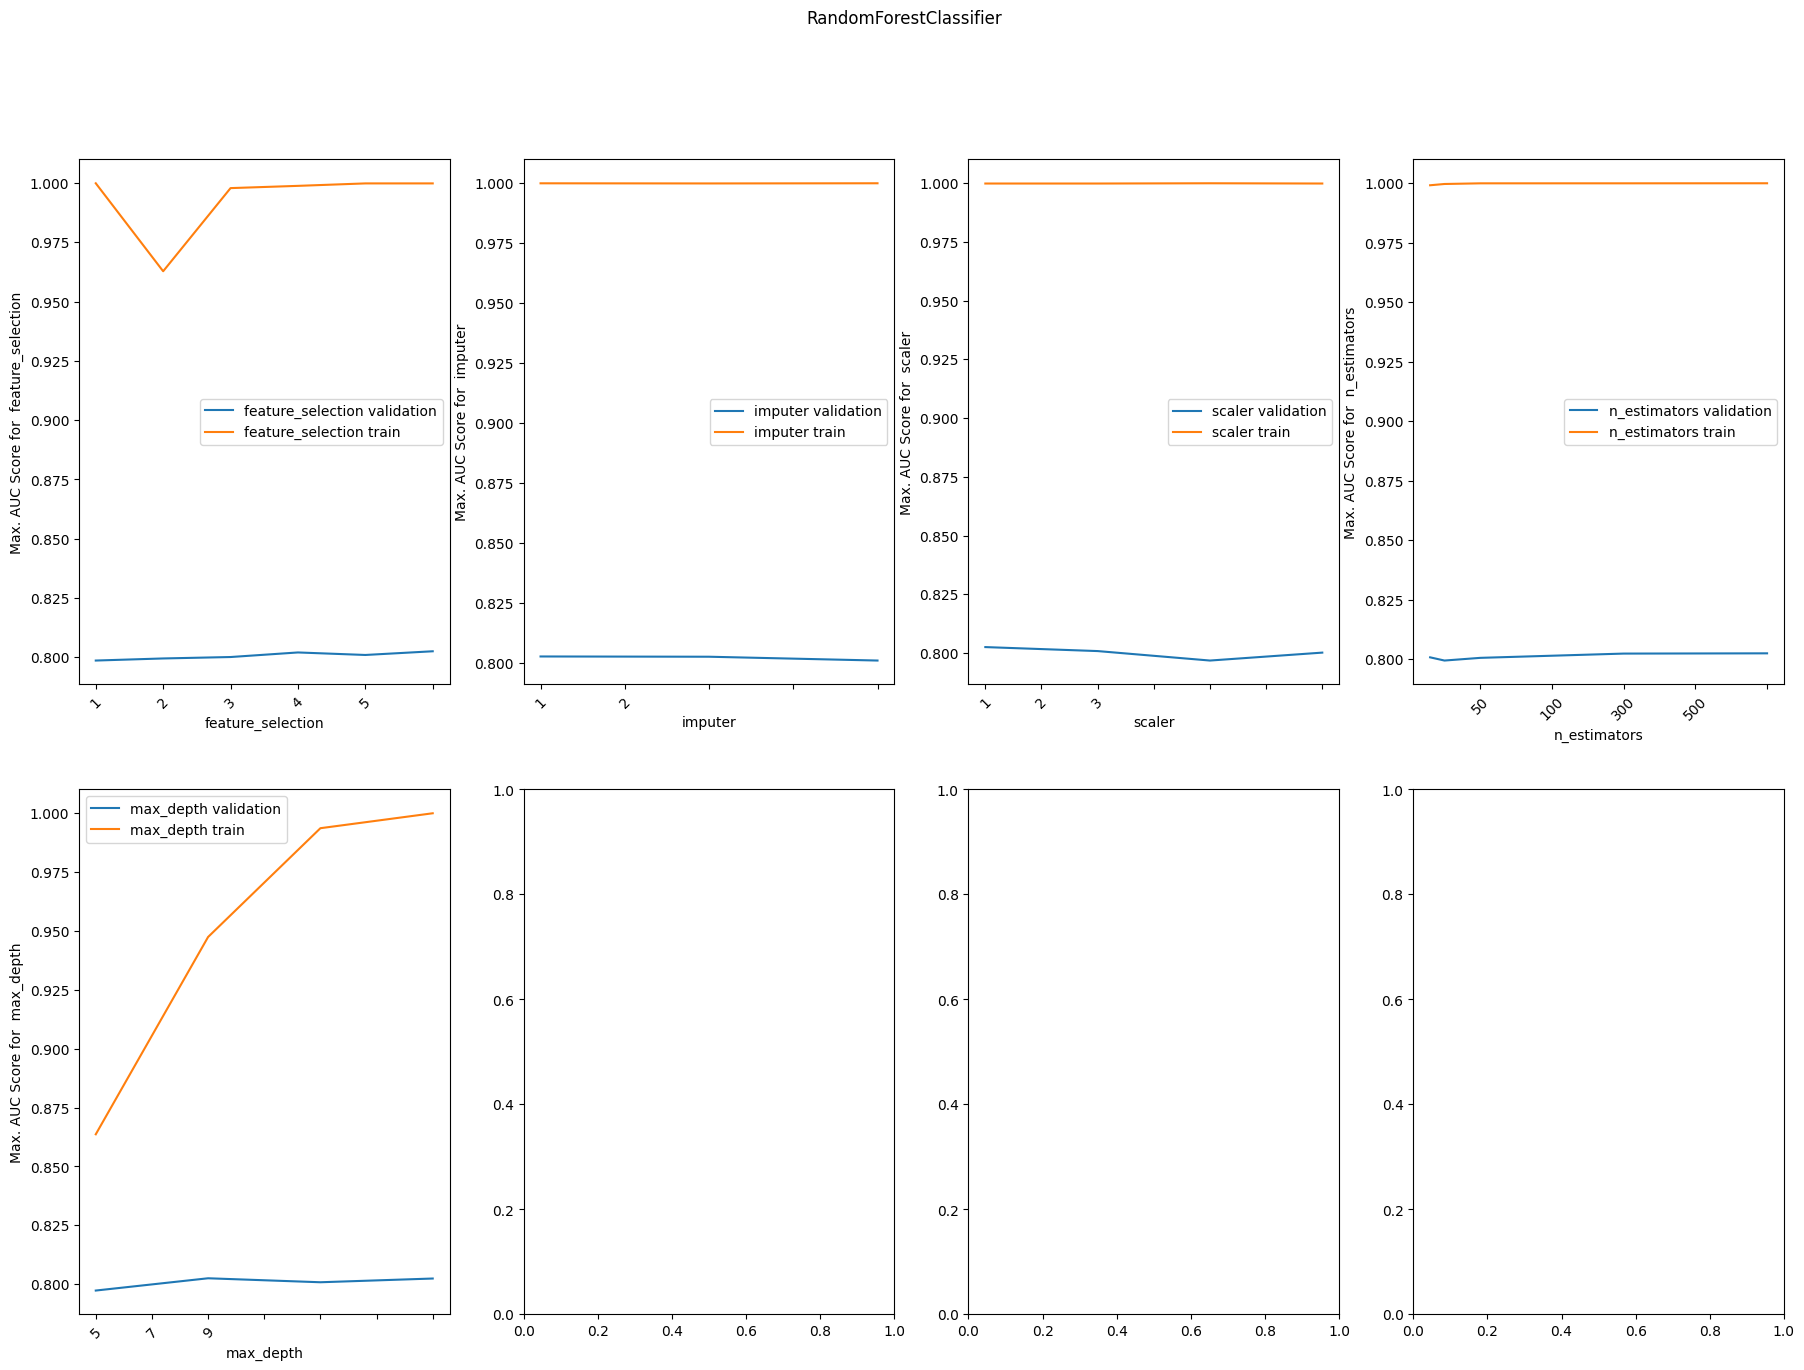

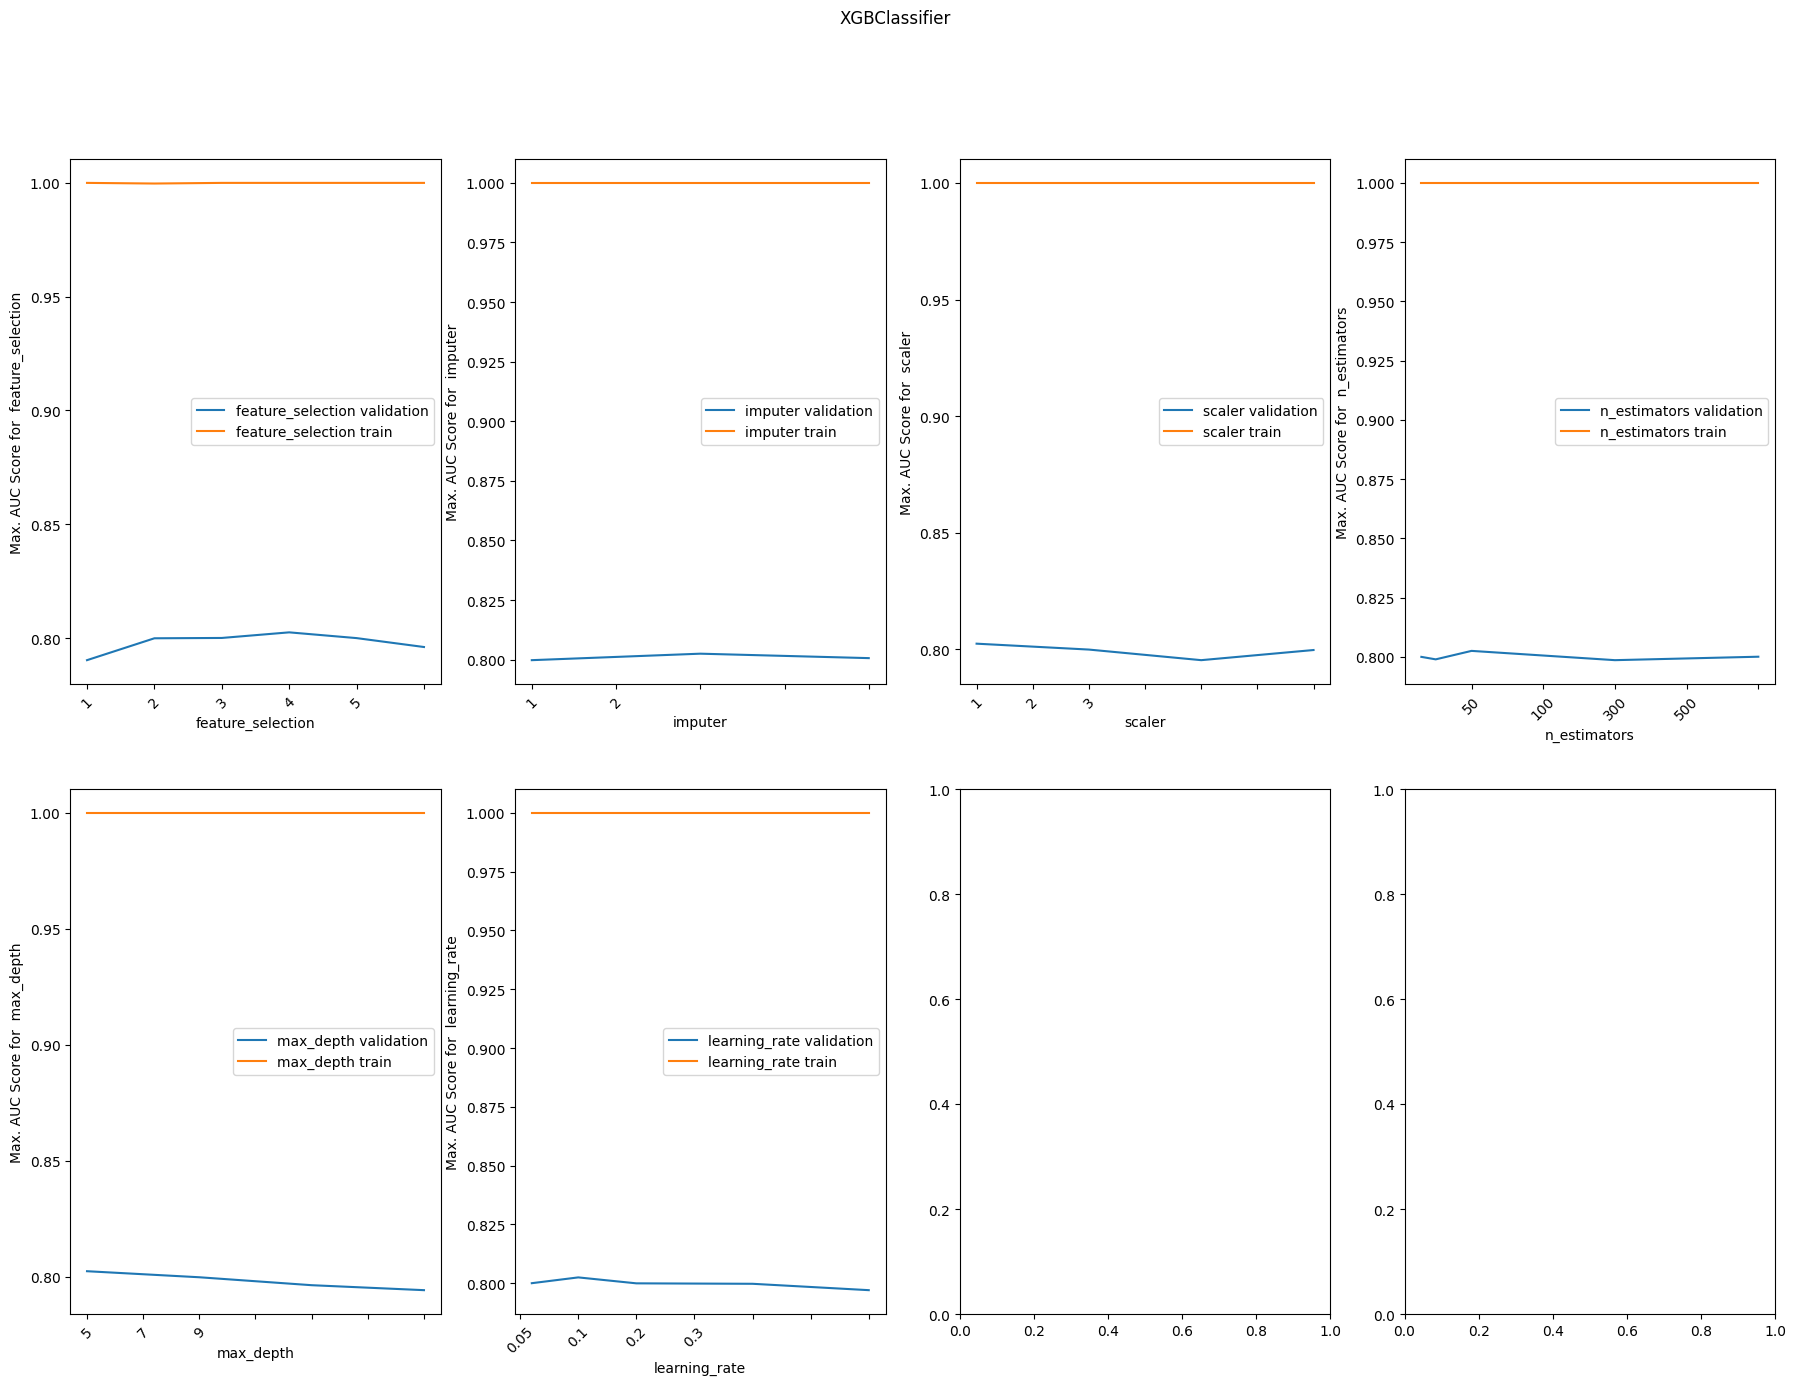

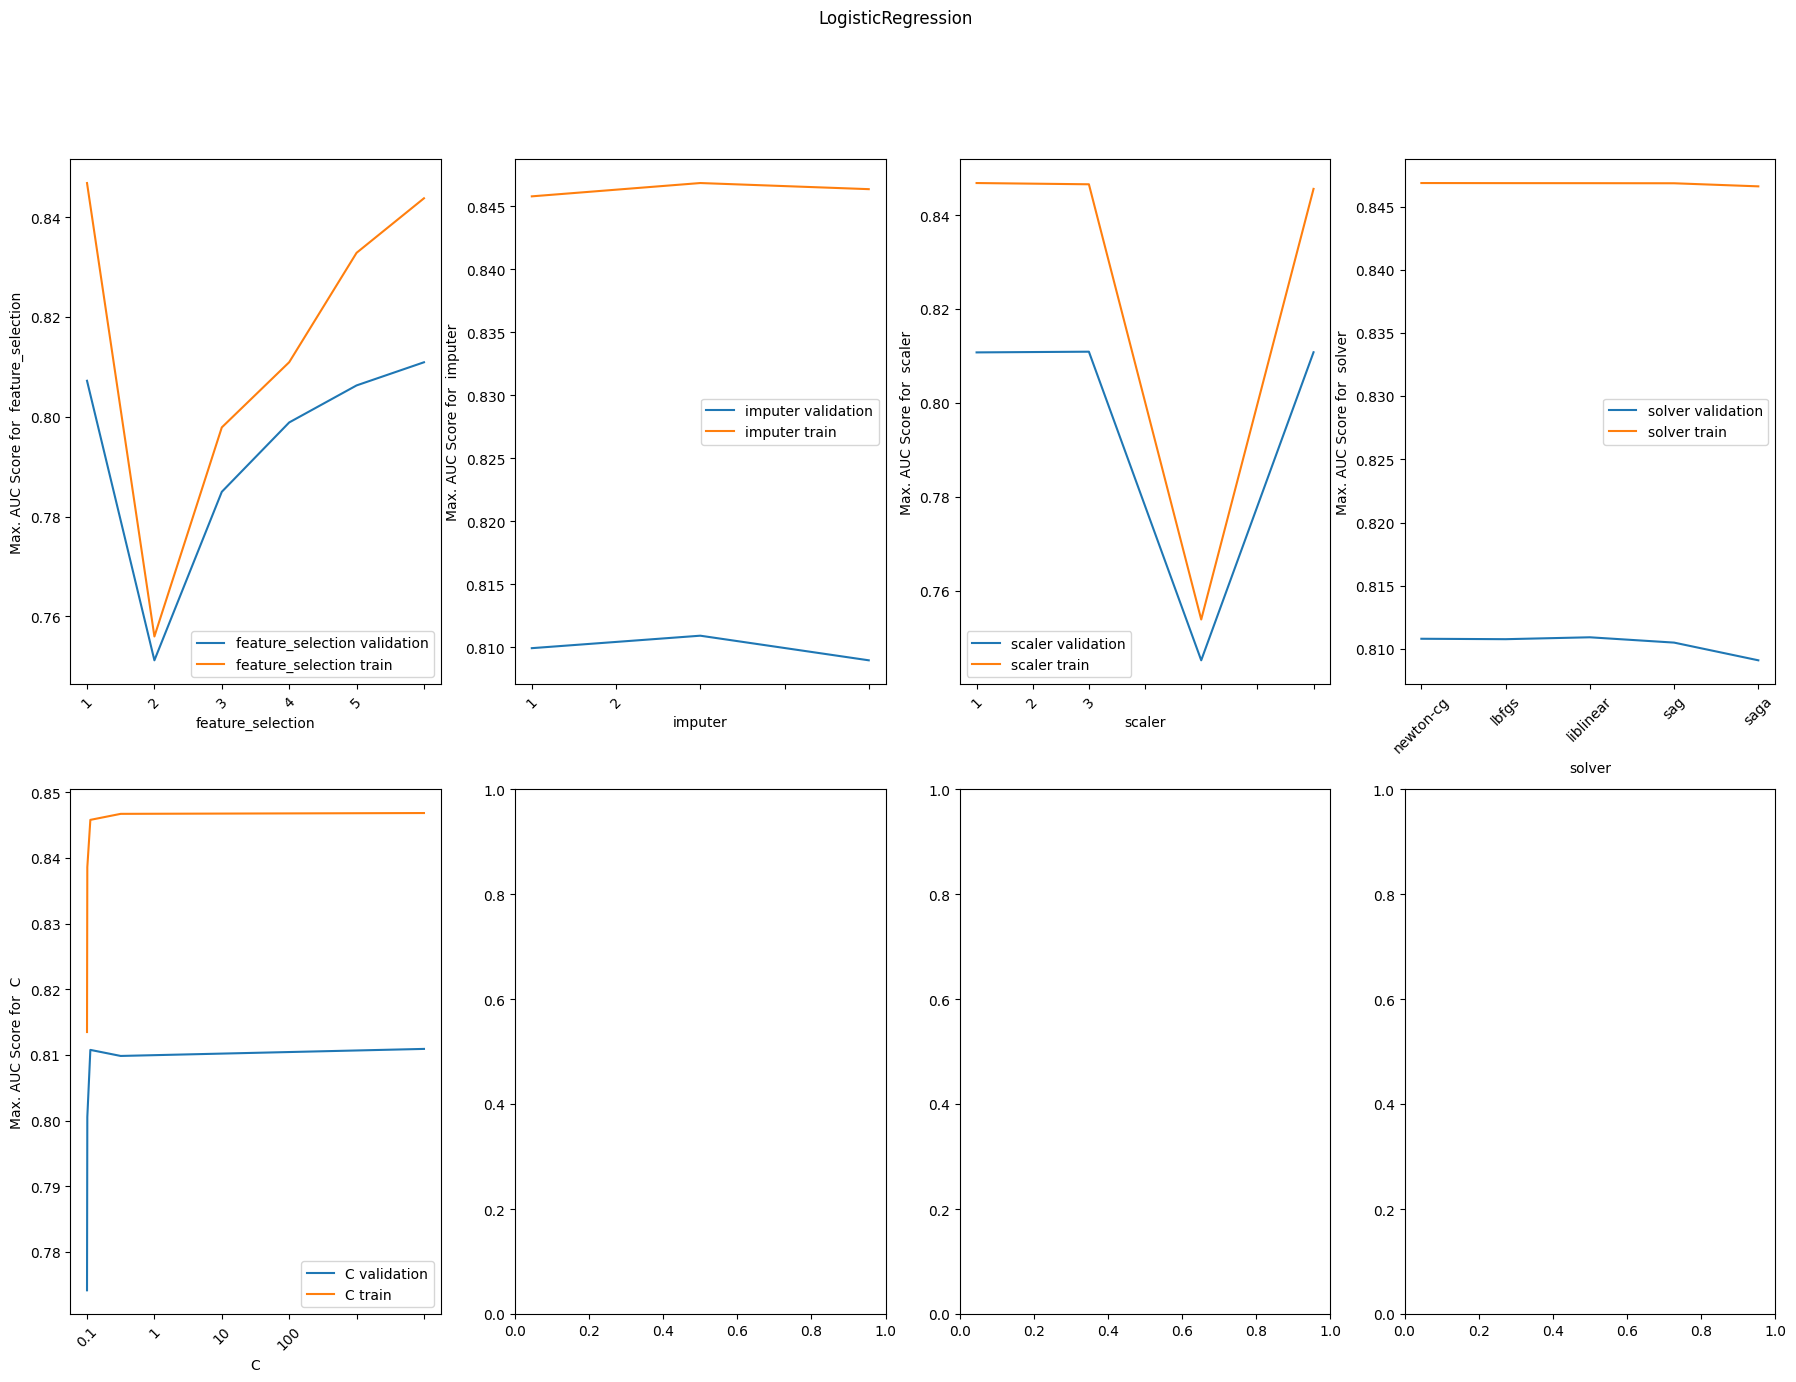

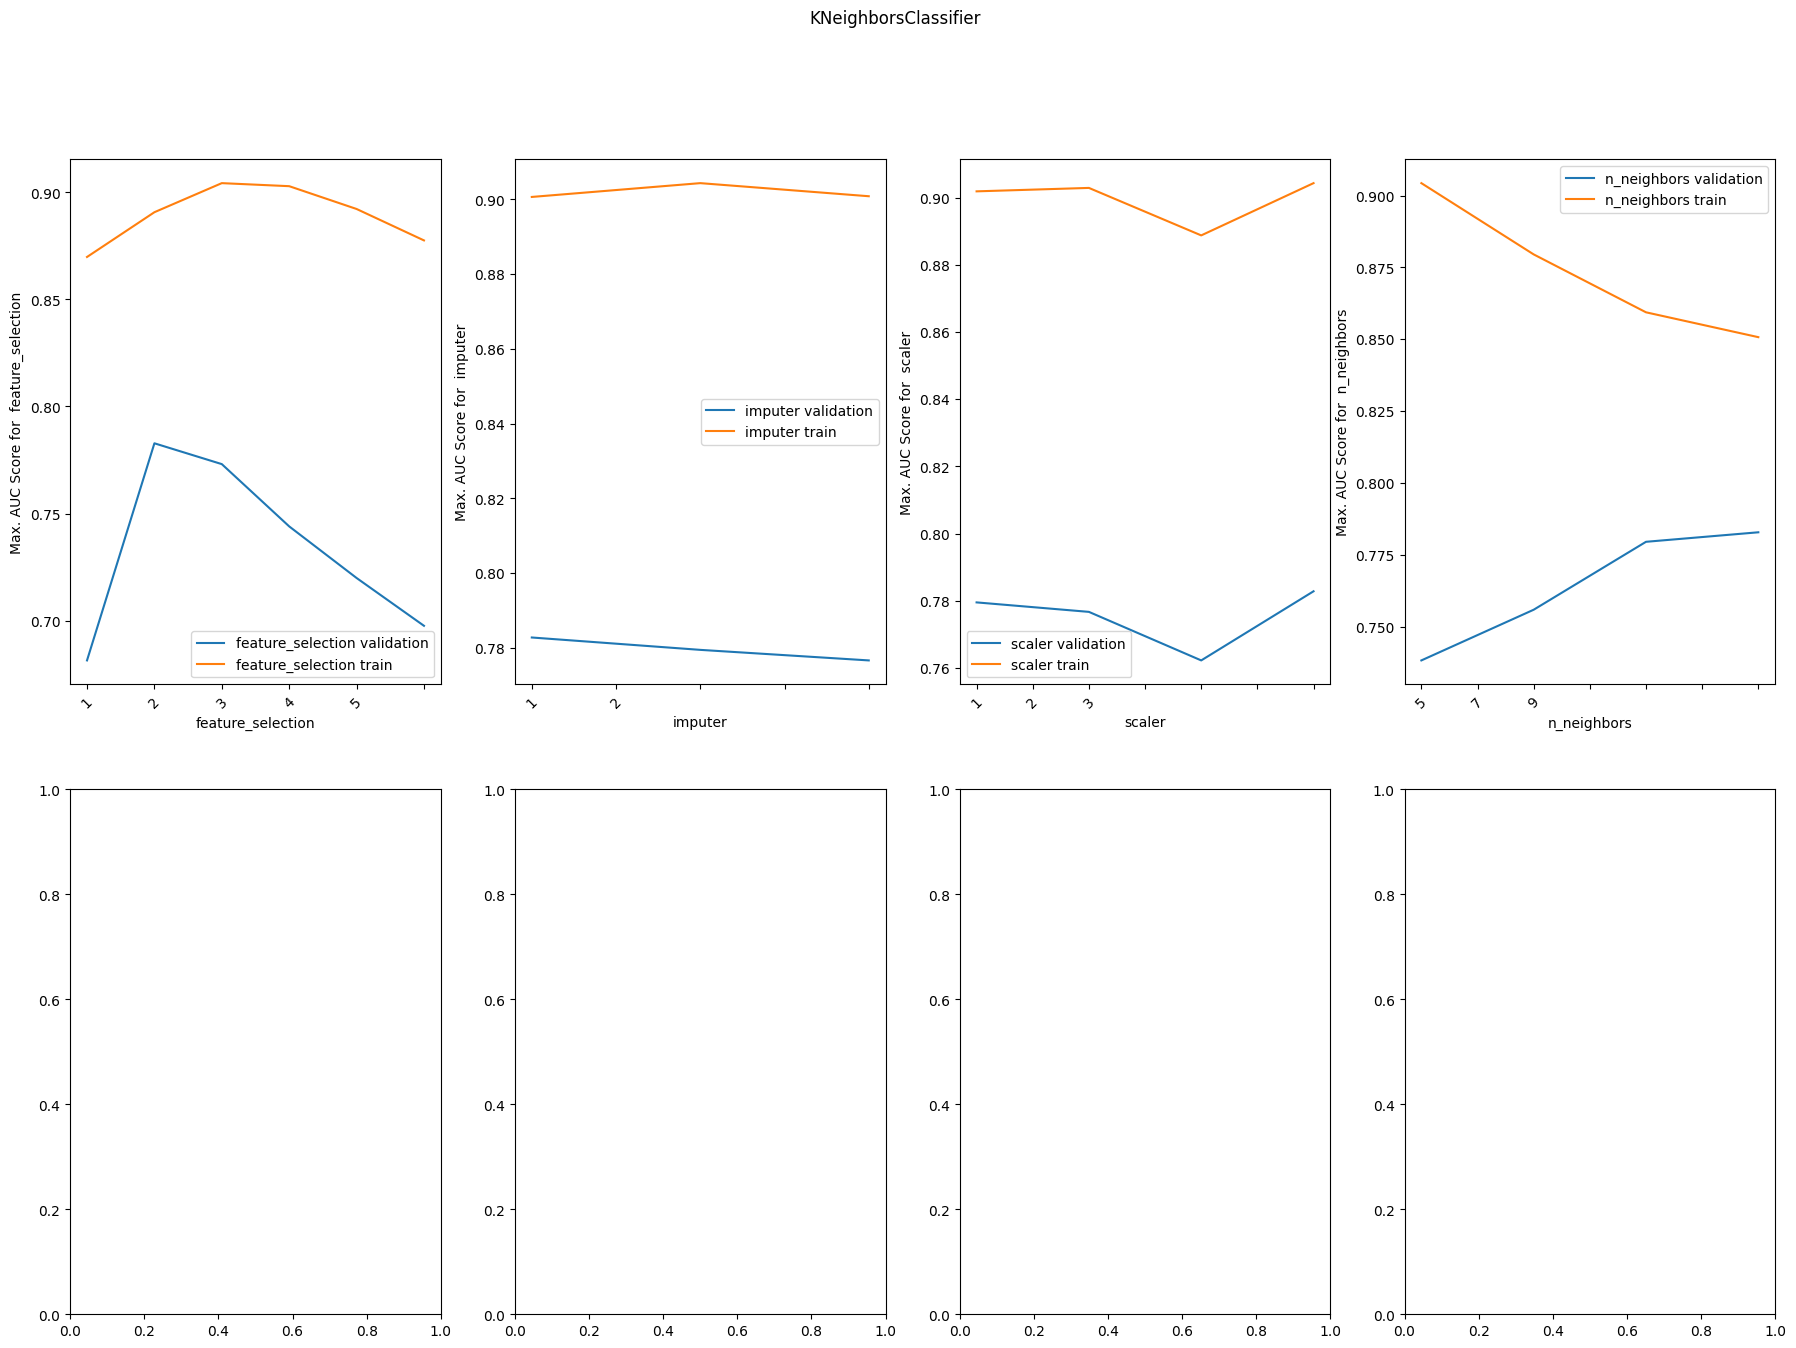

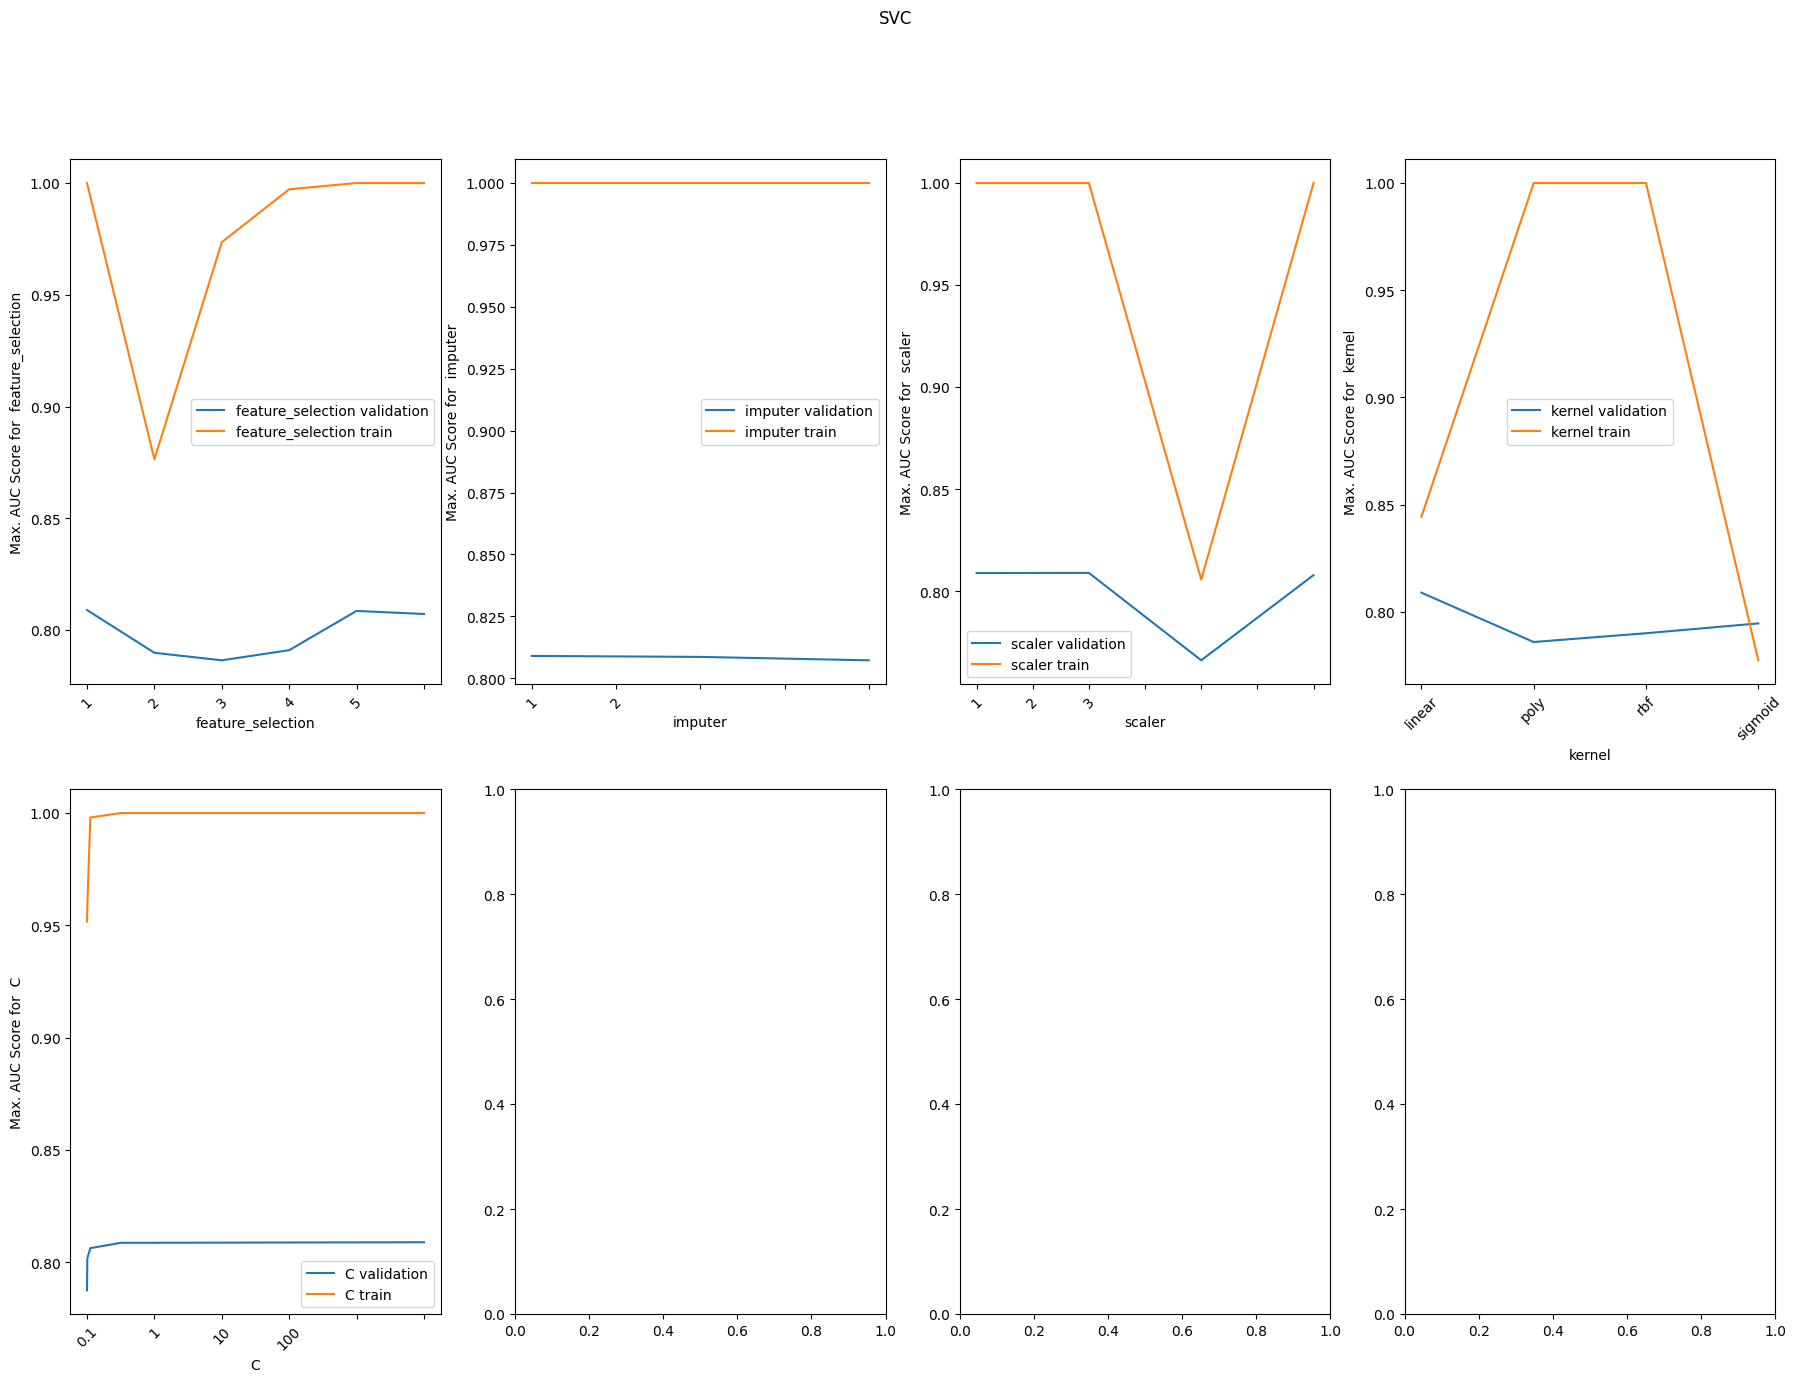

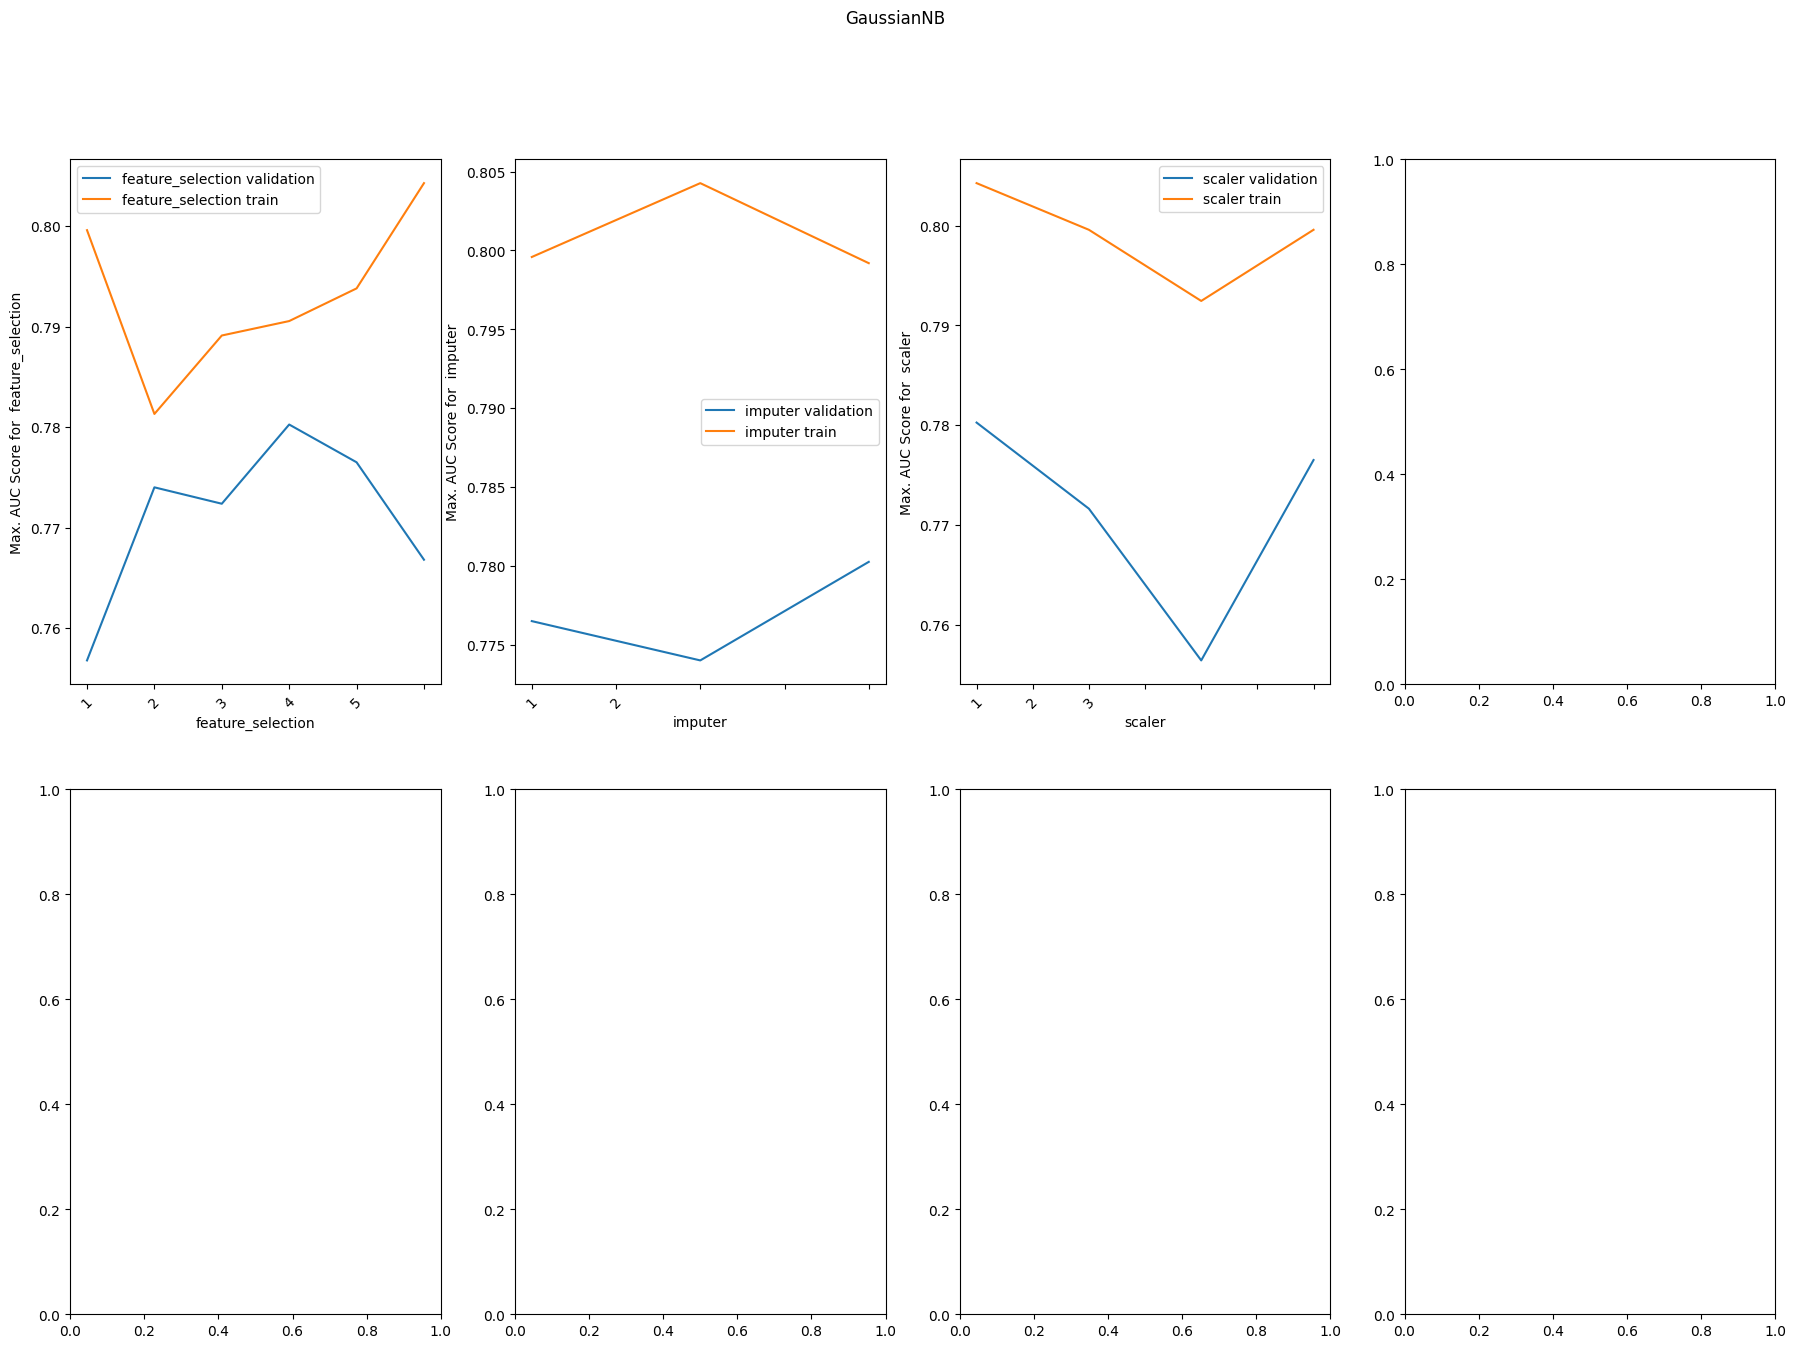

In [23]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    if "pca" in param_name:
        return "pca"
    if "scaler" in param_name:
        return "scaler"
    if "smote" in param_name:
        return "smote"
    if "imputer" in param_name:
        return "imputer"
    if "feature_selection" in param_name:
        return "feature_selection"
    return param_name

# print(cv_results["param_imputer"].value_counts())
# print(cv_results.columns)

for i, cv_result in enumerate(classifier_cv_results):
    cv_result_copy = cv_result.copy()
    cv_result_copy.columns = [shorten_param(col) for col in cv_result_copy.columns]
    # create a subplot for each hyperparameter
    fig, axes = plt.subplots(2, 4, figsize=(22, 15))
    # set figure title
    fig.suptitle(str(classifiers[i].__class__.__name__))
    col = 0
    row = 0
    # create a plot of each hyperparameter vs the score
    for param in param_grids[i].keys():
        # if we have filled all the subplots, move to the next row
        if col == 4:
            col = 0
            row += 1
        param = shorten_param(param)
        # use classname if not passthrough
        # cv_results['pca'] = cv_results['pca'].apply(lambda x: str(x.n_components) if isinstance(x, PCA) else x)
        # print(cv_result_copy[param].unique())
        print(param)
        
        # get indices of unique objects
        scalers = cv_result_copy['scaler'].unique()
        imputers = cv_result_copy['imputer'].unique()
        feature_selections = cv_result_copy['feature_selection'].unique()

        # map the hyperparameter to the index depending what unique object their are an instance of
        cv_result_copy['scaler'] = cv_result_copy['scaler'].apply(lambda x: np.where(scalers == x)[0][0])
        cv_result_copy['imputer'] = cv_result_copy['imputer'].apply(lambda x: np.where(imputers == x)[0][0])
        cv_result_copy['feature_selection'] = cv_result_copy['feature_selection'].apply(lambda x: np.where(feature_selections == x)[0][0])
       
        
        # cv_result_copy['smote'] = cv_result_copy['smote'].apply(lambda x: "Smote" if x != "passthrough" else "None" )
        # x is the values of the hyperparameter

        x = cv_result_copy[param].unique()
        if (len(x)== 1):
            continue
        # y is the mean score for each value of the hyperparameter
        max_test_scores = []
        max_train_scores = []
        for i in x:
            # calculate the mean and variance of the scores for each value of the hyperparameter
            max_test_scores.append(cv_result_copy[cv_result_copy[param] == i]["mean_test_score"].max())
            max_train_scores.append(cv_result_copy[cv_result_copy[param] == i]["mean_train_score"].max())
        # plot the mean and variance of the scores for each value of the hyperparameter
        axes[row, col].plot(x,max_test_scores, label=param+ " validation")
        axes[row, col].plot(x,max_train_scores, label=param+" train")
        axes[row, col].set_xlabel(param)
        axes[row, col].set_ylabel("Max. AUC Score for  " + param)
        # rotate the x axis labels
        axes[row, col].set_xticklabels(x, rotation=45)
        axes[row, col].legend()
        col += 1

## Evaluation on Test Set

                                                                 Accuracy   
DecisionTreeClassifier  [0.6679245283018868, 0.6716981132075471, 0.747...  \
RandomForestClassifier  [0.7509433962264151, 0.690566037735849, 0.7584...   
XGBClassifier           [0.769811320754717, 0.7018867924528301, 0.7396...   
LogisticRegression      [0.7584905660377359, 0.6754716981132075, 0.747...   
KNeighborsClassifier    [0.7245283018867924, 0.6528301886792452, 0.709...   
SVC                     [0.7735849056603774, 0.6754716981132075, 0.743...   
GaussianNB              [0.720754716981132, 0.6830188679245283, 0.7509...   

                                                                Precision   
DecisionTreeClassifier  [0.6162162162162163, 0.7647058823529411, 0.828...  \
RandomForestClassifier  [0.7124183006535948, 0.6923076923076923, 0.720...   
XGBClassifier           [0.7611940298507462, 0.7226890756302521, 0.736...   
LogisticRegression      [0.7557251908396947, 0.6885245901639344, 0.748...  

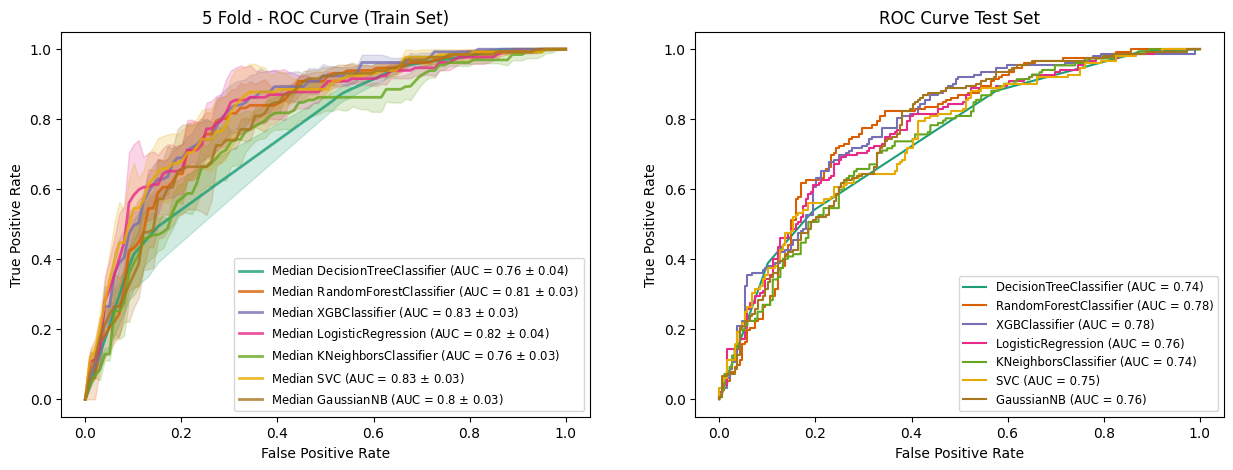

In [75]:
from sklearn.base import clone
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss

evaluation_train = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])
evaluation_test = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1', 'AUC'])

# create two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
colors = plt.get_cmap("Dark2")
for i, model in enumerate(best_models):
    name = model.__class__.__name__
    tprs = []
    aucs = []
    median_fpr = np.linspace(0, 1, 100)
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []
    for fold, (train, test) in enumerate(kfold.split(X_train_triage, y_train_triage)):
        model.fit(X_train_triage[train], y_train_triage[train])
        viz = RocCurveDisplay.from_estimator(
            model,
            X_train_triage[test],
            y_train_triage[test],
            alpha=0.3,
            lw=1,
            ax=axes[0],
        )
        viz.line_.set_visible(False)
        viz.line_.set_label(None)
        interp_tpr = np.interp(median_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)
        y_pred = model.predict(X_train_triage[test])
        accuracy_scores.append(accuracy_score(y_train_triage[test], y_pred))
        precision_scores.append(precision_score(y_train_triage[test], y_pred))
        recall_scores.append(recall_score(y_train_triage[test], y_pred))
        f1_scores.append(f1_score(y_train_triage[test], y_pred))
        y_pred_prob = model.predict_proba(X_train_triage[test])
        auc_scores.append(roc_auc_score(y_train_triage[test], y_pred_prob[:, 1]))
    evaluation_train.loc[name] = [
        accuracy_scores,
        precision_scores,
        recall_scores,
        f1_scores,
        auc_scores,
    ]

    median_tpr = np.median(tprs, axis=0)
    median_tpr[-1] = 1.0
    median_auc = auc(median_fpr, median_tpr)
    std_auc = np.std(aucs)
    axes[0].plot(
        median_fpr,
        median_tpr,
        color=colors(i),
        label="Median {} (AUC = {} $\pm$ {})".format(name, np.round(median_auc, 2), np.round(std_auc, 2)),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(median_tpr + std_tpr, 1)
    tprs_lower = np.maximum(median_tpr - std_tpr, 0)
    axes[0].fill_between(
        median_fpr,
        tprs_lower,
        tprs_upper,
        color=colors(i),
        alpha=0.2,
    )

    # now do the same for the test



    viz = RocCurveDisplay.from_estimator(
            model,
            X_test_triage,
            y_test_triage,
            alpha=1,
            ax=axes[1],
            color=colors(i),
            name=name
    )
    
    y_pred_proba = model.predict_proba(X_test_triage)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test_triage, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    evaluation_test.loc[name] = [
        accuracy_score(y_test_triage, model.predict(X_test_triage)),
        precision_score(y_test_triage, model.predict(X_test_triage)),
        recall_score(y_test_triage, model.predict(X_test_triage)),
        f1_score(y_test_triage, model.predict(X_test_triage)),
        roc_auc,
    ]

axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("5 Fold - ROC Curve (Train Set)")
axes[0].legend(fontsize='small')

axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve Test Set")
axes[1].legend(fontsize='small')

print(evaluation_train)
print(evaluation_test)

# make text editable in svg
plt.rcParams['svg.fonttype'] = 'none'
# save as svg
plt.savefig('./results/roc_curve_triage.svg', format='svg', dpi=1200)




In [73]:
# print train evaluation
evaluation_train_copy = evaluation_train.copy()
evaluation_train_copy['Accuracy'] = evaluation_train_copy['Accuracy'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
evaluation_train_copy['Precision'] = evaluation_train_copy['Precision'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
evaluation_train_copy['Recall'] = evaluation_train_copy['Recall'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
evaluation_train_copy['F1'] = evaluation_train_copy['F1'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
evaluation_train_copy['AUC'] = evaluation_train_copy['AUC'].apply(lambda x: str(round(np.mean(x), 2)) + " (" + str(round(np.std(x), 2))+")")
evaluation_train_copy.index = [classifier.__class__.__name__ for classifier in best_models]
evaluation_train_copy

,Accuracy,Precision,Recall,F1,AUC
DecisionTreeClassifier,0.7 (0.04),0.74 (0.09),0.66 (0.16),0.68 (0.06),0.76 (0.04)
RandomForestClassifier,0.73 (0.03),0.71 (0.01),0.78 (0.07),0.74 (0.04),0.81 (0.03)
XGBClassifier,0.74 (0.03),0.74 (0.02),0.72 (0.05),0.73 (0.03),0.82 (0.03)
LogisticRegression,0.73 (0.04),0.73 (0.03),0.71 (0.05),0.72 (0.04),0.81 (0.04)
KNeighborsClassifier,0.7 (0.03),0.68 (0.02),0.73 (0.07),0.7 (0.04),0.75 (0.03)
SVC,0.73 (0.04),0.73 (0.05),0.72 (0.03),0.73 (0.04),0.81 (0.03)
GaussianNB,0.72 (0.03),0.72 (0.02),0.71 (0.05),0.71 (0.03),0.79 (0.03)


In [74]:
# print test evaluation but we do not have std for test set
evaluation_test_copy = evaluation_test.copy()
evaluation_test_copy['Accuracy'] = evaluation_test_copy['Accuracy'].apply(lambda x: str(round(x, 2)))
evaluation_test_copy['Precision'] = evaluation_test_copy['Precision'].apply(lambda x: str(round(x, 2)))
evaluation_test_copy['Recall'] = evaluation_test_copy['Recall'].apply(lambda x: str(round(x, 2)))
evaluation_test_copy['F1'] = evaluation_test_copy['F1'].apply(lambda x: str(round(x, 2)))
evaluation_test_copy['AUC'] = evaluation_test_copy['AUC'].apply(lambda x: str(round(x, 2)))
evaluation_test_copy.index = [classifier.__class__.__name__ for classifier in best_models]
evaluation_test_copy


,Accuracy,Precision,Recall,F1,AUC
DecisionTreeClassifier,0.69,0.69,0.54,0.61,0.74
RandomForestClassifier,0.71,0.63,0.82,0.72,0.78
XGBClassifier,0.71,0.64,0.76,0.7,0.78
LogisticRegression,0.7,0.65,0.71,0.68,0.76
KNeighborsClassifier,0.67,0.6,0.76,0.67,0.74
SVC,0.64,0.59,0.64,0.61,0.75
GaussianNB,0.69,0.62,0.74,0.68,0.76


## Benchmarking

Exacerbation
0    589
1    547
Name: count, dtype: int64
ADO
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
DOSE
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
RF
Fitting 5 folds for each of 972 candidates, totalling 4860 fits


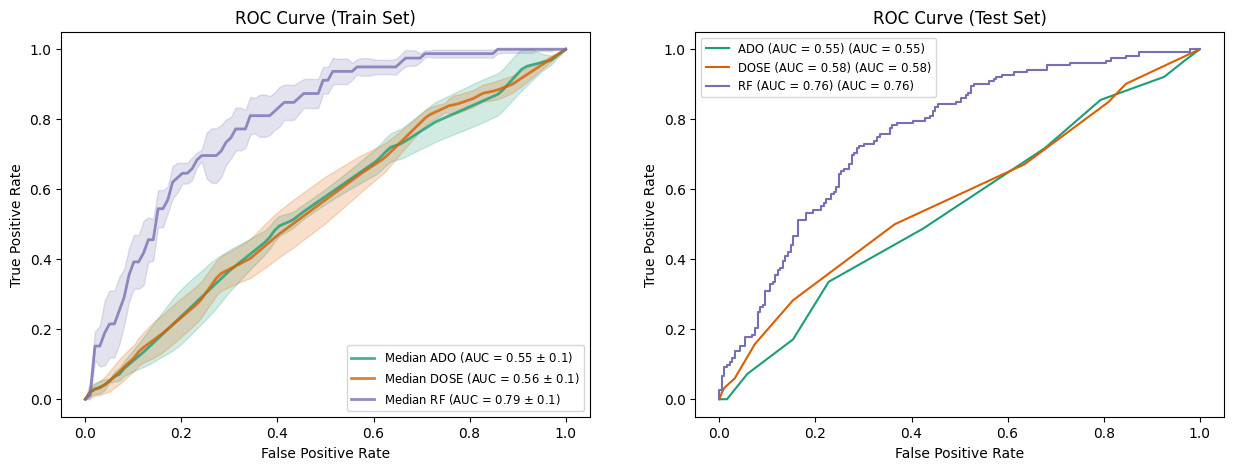

In [102]:
# https://www.thelancet.com/article/S0140-6736(09)61301-5/fulltext
def calculate_ADO(X):
    X['% FEV1 b'] = float(X['% FEV1 b'])
    X['MMRC b'] = float(X['MMRC b'])
    score = 0
    if X['Age'] >= 50 and X['Age'] <= 59:
        score += 1
    if X['Age'] >= 60 and X['Age'] <= 69:
        score += 2
    if X['Age'] >= 70 and X['Age'] <= 79:
        score += 3
    if X['Age'] >= 80 and X['Age'] <= 89:
        score += 4
    if X['Age'] >= 90:
        score += 5
    if X['MMRC b'] == 3:
        score += 1
    if X['MMRC b'] == 4:
        score += 2
    if X['MMRC b'] == 5:
        score += 3
    if X['% FEV1 b'] >= 36 and X['% FEV1 b'] <= 64:
        score += 1
    if X['% FEV1 b'] <= 35:
        score += 2
    return score

# https://www.atsjournals.org/doi/full/10.1164/rccm.200902-0271OC
def calculate_DOSE(X):
    X['% FEV1 b'] = float(X['% FEV1 b'])
    X['MMRC b'] = float(X['MMRC b'])
    score = 0
    if X['MMRC b'] == 3:
        score += 2
    if X['MMRC b'] == 4:
        score += 3
    if X['MMRC b'] == 5:
        score += 4
    if X['% FEV1 b'] >= 30 and X['% FEV1 b'] <= 49:
        score += 1
    if X['% FEV1 b'] < 30:
        score += 2
    # all patients smoke so add 1 point
    score += 1
    if X['2+ Exa. last year'] == 1:
        score += 3
    return score

triage_copy = df_triage.copy()
triage_copy.dropna(subset=['Exacerbation'], inplace=True)
# now only consider smokers
# triage_copy = triage_copy[triage_copy['Smoker'] == 1]
# get all the variables that are not the target variable
X = triage_copy.drop(columns=['Exacerbation'])
# get the target variable
y = triage_copy['Exacerbation']
print(y.value_counts())
y = LabelEncoder().fit_transform(y)

X_train_triage_copy, X_test_triage_copy, y_train_triage_copy, y_test_triage_copy = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_triage_copy['ADO'] = X_train_triage_copy.apply(calculate_ADO, axis=1)
X_train_triage_copy['DOSE'] = X_train_triage_copy.apply(calculate_DOSE, axis=1)
X_test_triage_copy['ADO'] = X_test_triage_copy.apply(calculate_ADO, axis=1)
X_test_triage_copy['DOSE'] = X_test_triage_copy.apply(calculate_DOSE, axis=1)

bode_results = []
ado_results = []
dose_results = []
# create a 1x2 figure
fig, ax = plt.subplots(1, 2, figsize=(15, 5))


model_names = ["ADO", "DOSE", "RF"]

columns = X_train_triage_copy.columns

# imputer
imputer = SimpleImputer(strategy='median')
X_train_triage_copy = imputer.fit_transform(X_train_triage_copy)
X_test_triage_copy = imputer.transform(X_test_triage_copy)

# scaler
scaler = StandardScaler()
X_train_triage_copy = scaler.fit_transform(X_train_triage_copy)
X_test_triage_copy = scaler.transform(X_test_triage_copy)

# turn it into a dataframe again
X_train_triage_copy = pd.DataFrame(X_train_triage_copy, columns=columns)
X_test_triage_copy = pd.DataFrame(X_test_triage_copy, columns=columns)

colors = plt.get_cmap("Dark2")


# check if all bertens columns are in the dataframe
for i, model_name in enumerate(model_names):
    tprs = []
    median_fpr = np.linspace(0, 1, 100)


    print(model_name)
    # perform k-fold cross validation on train set
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    auc_scores = []
    X_train_selection = None
    X_test_selection = None
    model = LogisticRegression(random_state=42, class_weight='balanced', n_jobs=-1, solver='liblinear')
    params = {
        "penalty" : ["l2","l1"],
        "tol" : [0.0001,0.0002,0.0003],
        "max_iter": [100,200,300],
        "C" :[0.001,0.01, 0.1, 1, 10, 100],
        "intercept_scaling": [1, 2, 3, 4],
    }
    if model_name == "RF":
        model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample')
        params = {
            'criterion':['gini','entropy'],
            'n_estimators':[10,20,30],
            'min_samples_leaf':[1,3,5],
            'min_samples_split':[3,5,7], 
            'max_features':['auto','sqrt','log2'],
            'max_depth':[2,3,5],
            'class_weight' : ["balanced", "balanced_subsample"]
        }
        X_train_selection = X_train_triage_copy[candidate_predictors].to_numpy()
        X_test_selection = X_test_triage_copy[candidate_predictors].to_numpy()
    else:
        X_train_selection = X_train_triage_copy[model_name].values.reshape(-1, 1)
        X_test_selection = X_test_triage_copy[model_name].values.reshape(-1, 1)
    # perform a grid search
    grid_search = GridSearchCV(estimator=model,
        param_grid=params,
        scoring='roc_auc',
        cv=kfold,  
        return_train_score=True, 
        verbose=1,
        n_jobs=-1
    )
    grid_search.fit(X_train_selection, y_train_triage_copy)
    model = grid_search.best_estimator_
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train, test) in enumerate(kfold.split(X_train_selection, y_train_triage_copy)):
        # get BODE column with train indices
        model.fit(X_train_selection[train], y_train_triage_copy[train])
        y_pred = model.predict(X_train_selection[test])
        y_pred_prob = model.predict_proba(X_train_selection[test])
        fpr,tpr, _ = roc_curve(y_train_triage_copy[test], model.predict_proba(X_train_selection[test])[:, 1])
        interp_tpr = np.interp(median_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)

        accuracy_scores.append(accuracy_score(y_train_triage_copy[test], y_pred))
        precision_scores.append(precision_score(y_train_triage_copy[test], y_pred))
        recall_scores.append(recall_score(y_train_triage_copy[test], y_pred))
        f1_scores.append(f1_score(y_train_triage_copy[test], y_pred))
        auc_scores.append(roc_auc_score(y_train_triage_copy[test], y_pred_prob[:, 1]))

    median_tpr = np.median(tprs, axis=0)
    median_tpr[-1] = 1.0
    median_auc = np.median(auc_scores)
    std_auc = np.std(aucs)
    ax[0].plot(
        median_fpr,
        median_tpr,
        color=colors(i),
        label="Median {} (AUC = {} $\pm$ {})".format(model_name, np.round(median_auc, 2), np.round(std_auc, 2)),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(median_tpr + std_tpr, 1)
    tprs_lower = np.maximum(median_tpr - std_tpr, 0)
    ax[0].fill_between(
        median_fpr,
        tprs_lower,
        tprs_upper,
        color=colors(i),
        alpha=0.2,
    )
    roc_test = roc_auc_score(y_test_triage_copy, model.predict_proba(X_test_selection)[:, 1])
    viz = RocCurveDisplay.from_estimator(
        model,
        X_test_selection,
        y_test_triage_copy,
        alpha=1,
        ax=ax[1],
        name="{index} (AUC = {auc})".format(index=model_name, auc=np.round(roc_test, 2)),
        color=colors(i),
    )

ax[0].set_xlabel("False Positive Rate")
ax[0].set_ylabel("True Positive Rate")
ax[0].set_title("ROC Curve (Train Set)")
ax[0].legend(fontsize='small')

ax[1].set_xlabel("False Positive Rate")
ax[1].set_ylabel("True Positive Rate")
ax[1].set_title("ROC Curve (Test Set)")
ax[1].legend(fontsize='small')

# make text editable in svg
plt.rcParams['svg.fonttype'] = 'none'
# save as svg
plt.savefig('./results/benchmarking_roc_curve_triage.svg', format='svg', dpi=1200)

# BODEx: BMI, fev1, mmrc, 6MWD, exacerbation
# Bertens: prev. exa, % pred. FEV1, pack years, history of vascular disease
# Accept: Age, % pred FEV1, BMI, SGRQ, Sex, Current-Smoker, On-Statin, O2-Therapy, On-LAMA, On-LABA, On-ICS